### Prepare Workspace

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/model-the-impossible-predicting-ph-earthquakes/sample_submission.csv
/kaggle/input/model-the-impossible-predicting-ph-earthquakes/train.csv
/kaggle/input/model-the-impossible-predicting-ph-earthquakes/test.csv


In [2]:
! pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 3.2 MB/s eta 0:00:00


In [3]:
! pip install sklearn-quantile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.0/481.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sklearn-quantile: filename=sklearn_quantile-0.0.19-cp37-cp37m-linux_x86_64.whl size=1808983 sha256=ca96235a37cae506ceb46b1a58e2cbb9472fdd9f9b90eeb93e1f72299caa0b5b
  Stored in directory: /root/.cache/pip/wheels/fb/94/e8/930977e0cb98f988f136156a070e2ddc839af2fbd620071fc1
Successfully built sklearn-quantile


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import datetime
import scipy
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from feature_engine.timeseries.forecasting import WindowFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn_quantile import (
    RandomForestQuantileRegressor,
    KNeighborsQuantileRegressor)
from sklearn.inspection import PartialDependenceDisplay
from feature_engine.encoding import MeanEncoder
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load Data Set

In [5]:
df = pd.read_csv('/kaggle/input/model-the-impossible-predicting-ph-earthquakes/train.csv',     
    index_col=0,parse_dates=True)

### Have a look at the data set

In [6]:
print(df.shape)

(10188, 9)


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10188 entries, 1979-11-12 14:46:47.800000+00:00 to 2010-06-12 00:14:12.100000+00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        10188 non-null  float64
 1   longitude       10188 non-null  float64
 2   depth           10188 non-null  float64
 3   mag             10188 non-null  float64
 4   magType         10188 non-null  object 
 5   place           10188 non-null  object 
 6   type            10188 non-null  object 
 7   locationSource  10188 non-null  object 
 8   magSource       10188 non-null  object 
dtypes: float64(4), object(5)
memory usage: 795.9+ KB
None


In [8]:
print(df.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'magType', 'place', 'type',
       'locationSource', 'magSource'],
      dtype='object')


In [9]:
print(df.head())

                                  latitude  longitude  depth  mag magType  \
time                                                                        
1979-11-12 14:46:47.800000+00:00     9.752    125.935  106.0  5.0      mb   
1979-11-18 15:59:20.500000+00:00    11.327    125.690   43.0  5.0      mb   
1979-11-19 22:17:20.200000+00:00     5.861    125.295   85.0  6.1      mb   
1979-11-21 22:59:05.300000+00:00     5.571    127.016   63.0  4.8      mb   
1979-11-22 18:39:07.600000+00:00    16.339    121.586   33.0  4.8      mb   

                                                      place        type  \
time                                                                      
1979-11-12 14:46:47.800000+00:00      Mindanao, Philippines  earthquake   
1979-11-18 15:59:20.500000+00:00         Samar, Philippines  earthquake   
1979-11-19 22:17:20.200000+00:00      Mindanao, Philippines  earthquake   
1979-11-21 22:59:05.300000+00:00  Philippine Islands region  earthquake   
1979-11-22

### Data Cleaning

In [10]:
# Delete duplicate columns
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
to_del

[6]

In [11]:
# Delete duplicate columns
df.drop(['locationSource'], axis=1, inplace=True)
print(df.shape)

(10188, 8)


In [12]:
# Delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(10188, 8)


In [13]:
# Check missing values 
missing = df.isnull().sum()/df.shape[0]*100
missing

latitude     0.0
longitude    0.0
depth        0.0
mag          0.0
magType      0.0
place        0.0
type         0.0
magSource    0.0
dtype: float64

In [14]:
df.index.min()

Timestamp('1979-11-12 14:46:47.800000+0000', tz='UTC')

In [15]:
df.index.max()

Timestamp('2010-06-12 00:14:12.100000+0000', tz='UTC')

In [16]:
# formatting features
df.index = pd.to_datetime(df.index)

### Summary Statistics

In [17]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
df[obj_cols].describe().T

,count,unique,top,freq
magType,10188,5,mb,9116
place,10188,25,"Mindanao, Philippines",3951
type,10188,1,earthquake,10188
magSource,10188,4,us,9277


In [18]:
# Summarize attribute distributions for data type of variables
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,10188.0,10.295055,3.775376,4.632,6.748,9.867,13.225,19.041
longitude,10188.0,124.567383,2.436067,117.115,122.584,125.605,126.438,129.797
depth,10188.0,70.589694,92.418147,1.100,33.000,34.450,74.800,678.000
mag,10188.0,4.630752,0.472133,3.000,4.300,4.600,4.900,7.700


### Functions

In [19]:
# Vis Chart
def plot_target(data, var):
    plt.rcParams['figure.figsize']=(20,15)
    plt.suptitle('Earthquake Magnitude Exploratory Data Analysis',fontsize=25)
    plt.subplot(2,2,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.xticks(rotation=45)
    
    plt.subplot(2,2,4)
    # autocorrelation plot 
    autocorrelation_plot(df[var])
    plt.title("{} vs time autocorrelation".format(var)) 
    
    plt.show()

In [20]:
def barplot(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['mag'].mean()
    df.plot.bar(color='blue')
    plt.suptitle('Distribution Magnitude per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=20)
    plt.ylabel('mag', fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [21]:
def tsplot(data,var,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data[var], linewidth=3, color='Orange')
    else:
        plt.plot(data[var].loc[period], linewidth=3,color='Orange') 
    plt.suptitle('Earthquake Magnitude Time Series',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('{}'.format(var), fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [22]:
def tsmultiplot(data,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data, linewidth=3)
    else:
        plt.plot(data.loc[period], linewidth=3) 
    my_labels=['Mag_Actual', 'Mag_Prediction']
    plt.suptitle('Earthquake Magnitude Time Series: Actual vs Prediction',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Actual vs Prediction',fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.legend(my_labels,fontsize=20)
    plt.show()

In [23]:
# Evaluation function
def evaluate(model, X, y, cv):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "root_mean_squared_error": np.sqrt(mean_squared_error(y, y_pred)),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
        }
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=score_func,
        return_train_score=True
    )
    
    print('Train evaluation')
    for key, value in cv_results.items():
        if key.startswith("train_"):
            print(f"{key[6:]}: {value.mean():.3f} ± {value.std():.3f}")
 
    print('Test evaluation')
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")

In [24]:
def piechart(data, col1, col2):
    # Plot the target variable 
    plt.rcParams['figure.figsize']=(20,10)
    plt.subplot(1,2,1)
    data.groupby(col1).count()[col2].plot(kind='pie',autopct='%.0f%%').set_title("Pie {} Variable Distribution".format(col1))
    plt.subplot(1,2,2)
    sns.countplot(x=data[col1], data=data).set_title("Barplot {} Variable Distribution".format(col1))
    plt.show()

In [25]:
def plot_num(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    plt.subplot(1,3,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(1,3,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(1,3,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.show()

In [26]:
# Function for query and barplot 
def query(data,col):
    # groupby
    df = data.groupby(data[col], as_index=False)['mag'].max()
    df['PERCENTAGE'] = df['mag']/df['mag'].sum()*100
    # dropping not matching rows
    df = df.dropna()
    # ranking 
    df = df.sort_values(by = 'mag', ascending = False).reset_index(drop=True)
    df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Customer_Lifetime_Value':"{:,.2f}"})
    # barplot
    index=list(df.columns[0:1])
    barplot = df[df.columns[0:2]].sort_values(by = "mag", ascending = True).set_index(index).plot.barh()
    plt.xticks(rotation=0)
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
    return df_q
    plt.show()
    return barplot
    plt.show()

### Target Variable Analysis

In [27]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
print('\nMean :', np.mean(df['mag']),  
        '\nVariance :', np.var(df['mag']),
        '\nStandard Deviation :', np.var(df['mag']**0.5), 
        '\nSkewness :', stats.skew(df['mag']), 
        '\nKurtosis :', stats.kurtosis(df['mag']))


Mean : 4.630751864939144 
Variance : 0.2228872635173308 
Standard Deviation : 0.011575609886290344 
Skewness : 1.064887195998622 
Kurtosis : 3.2781340208869736


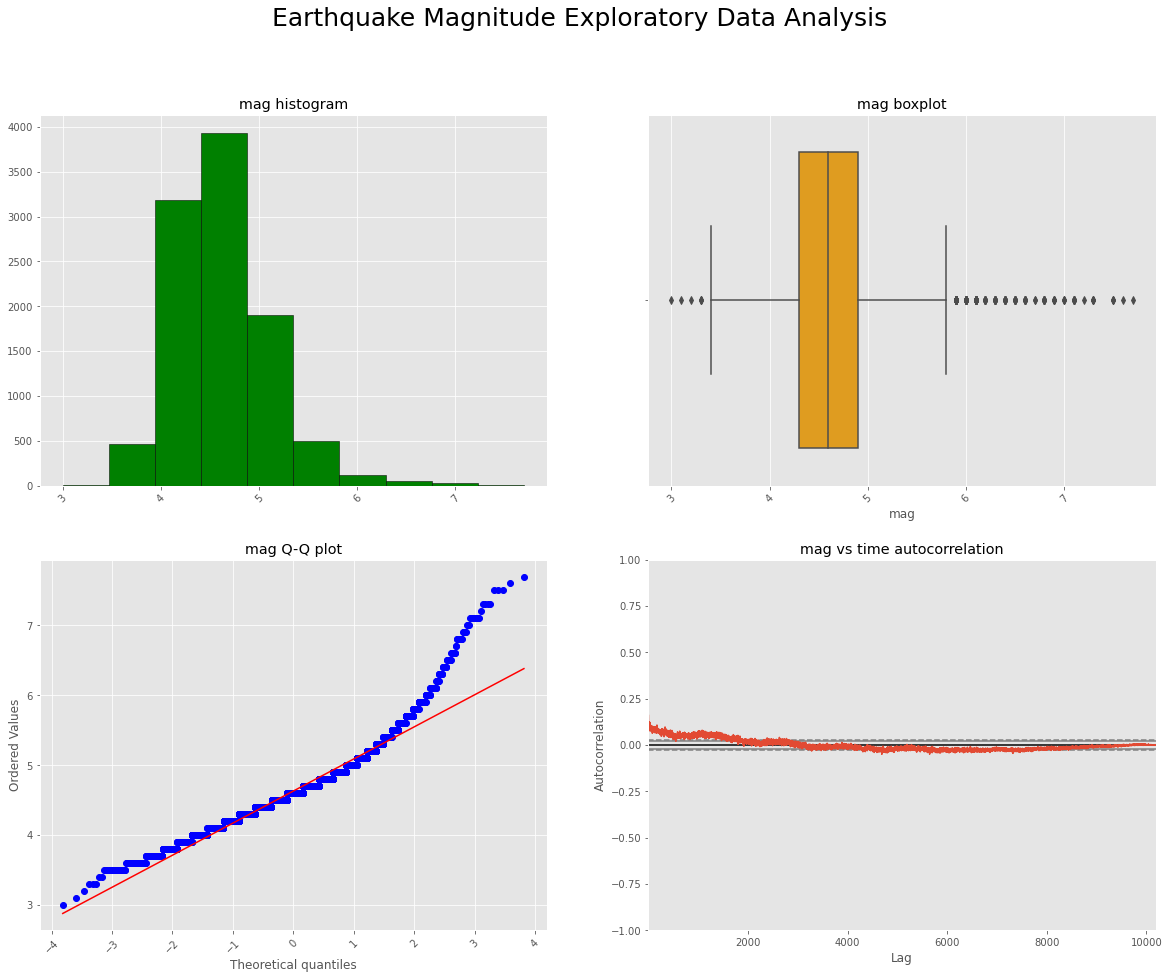

In [28]:
plot_target(df, var='mag')

In [29]:
df1 = df.copy()

In [30]:
df1['year'] = pd.DatetimeIndex(df.index).year 
df1['month'] = pd.DatetimeIndex(df.index).month
df1['day'] = pd.DatetimeIndex(df.index).day
df1['hour'] = pd.DatetimeIndex(df.index).hour

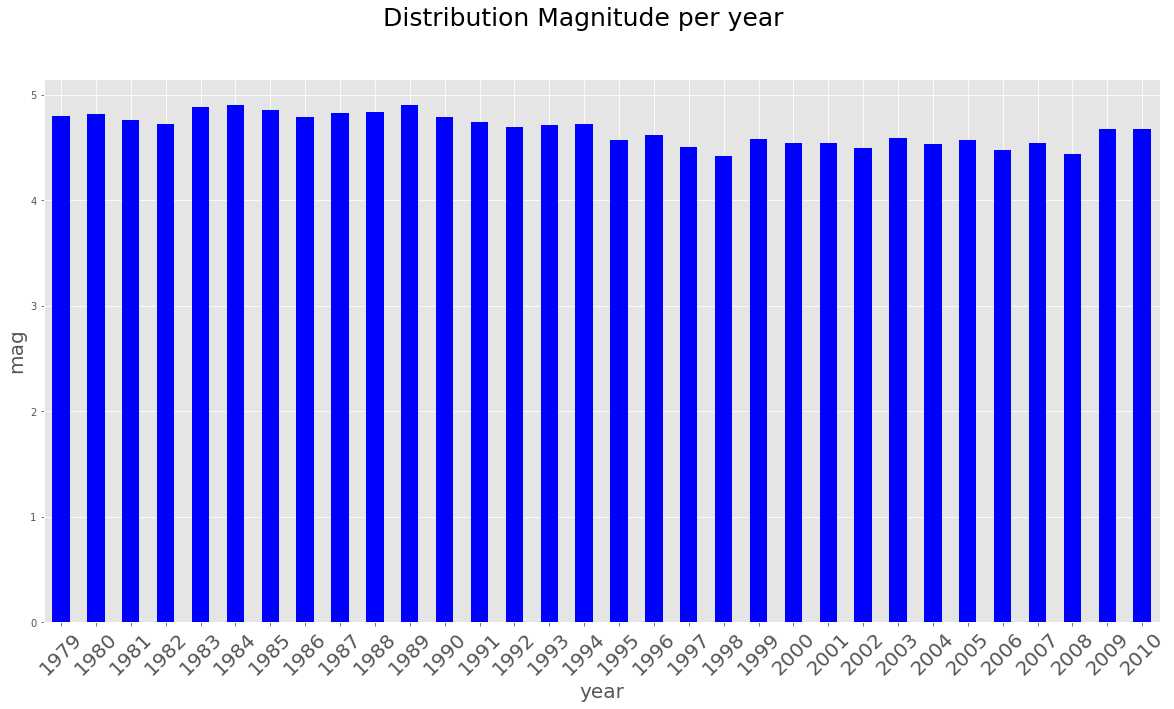

In [31]:
barplot(df1, var='year')

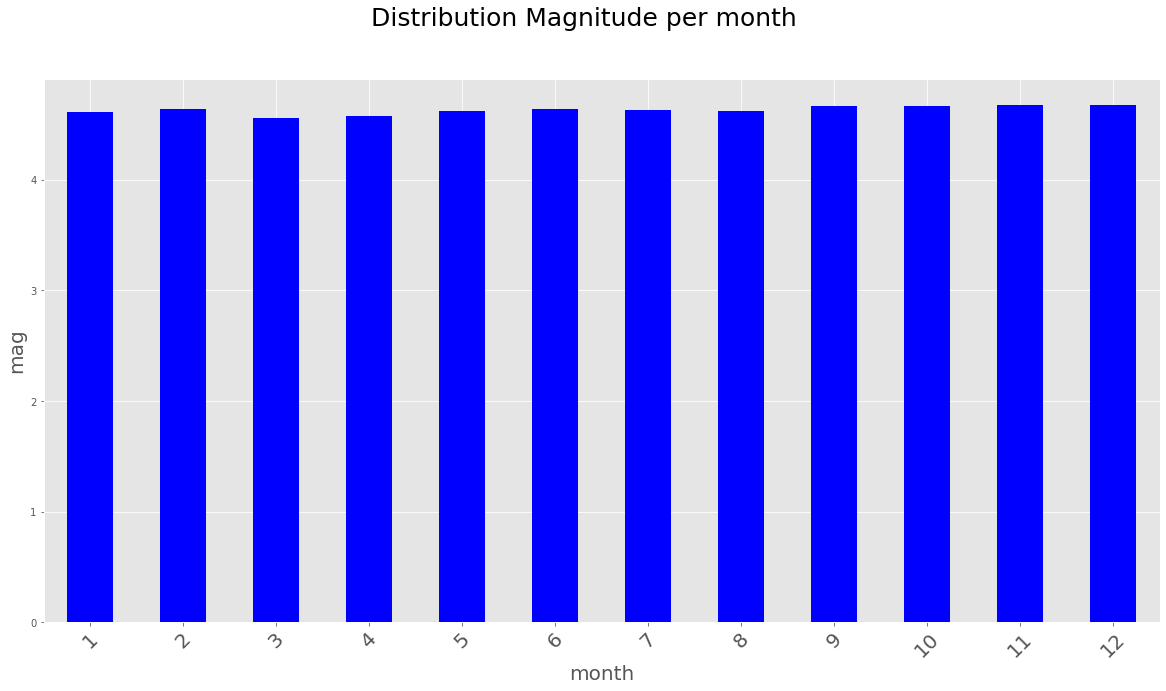

In [32]:
barplot(df1, var='month')

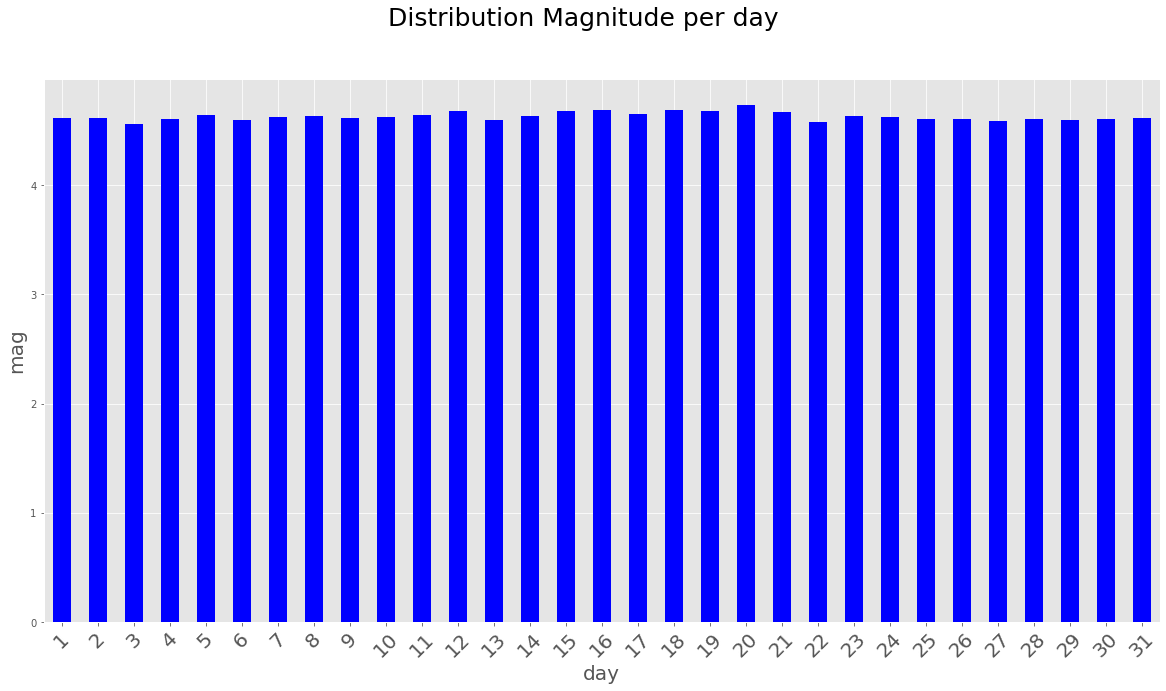

In [33]:
barplot(df1, var='day')

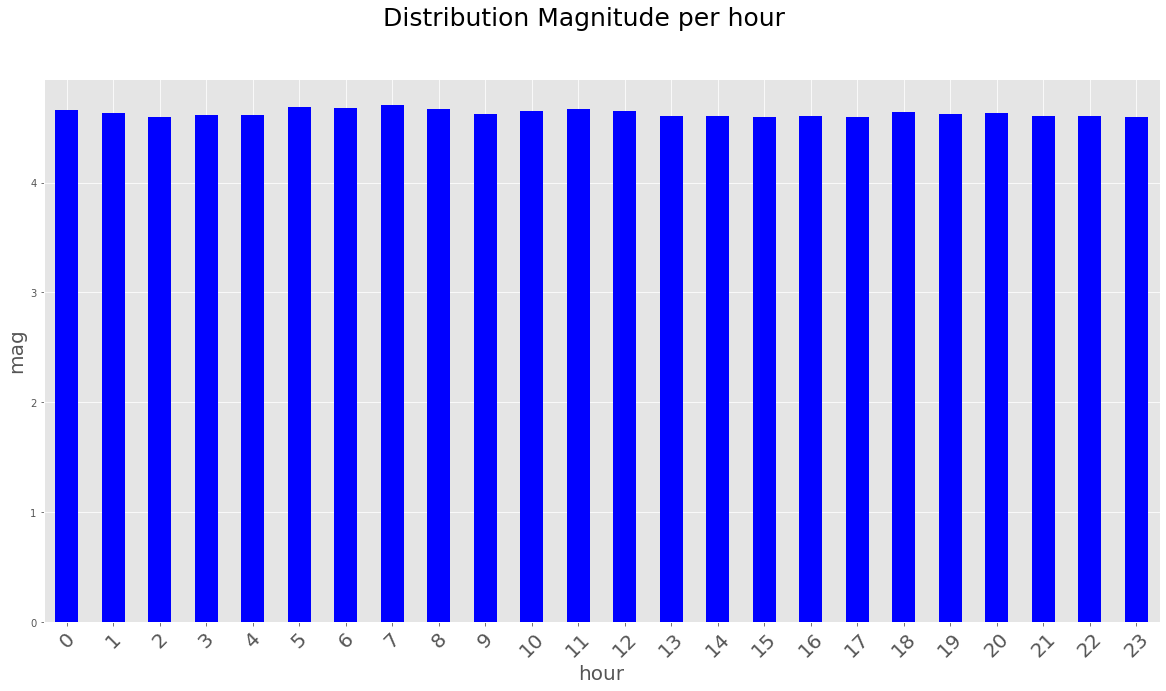

In [34]:
barplot(df1, var='hour')

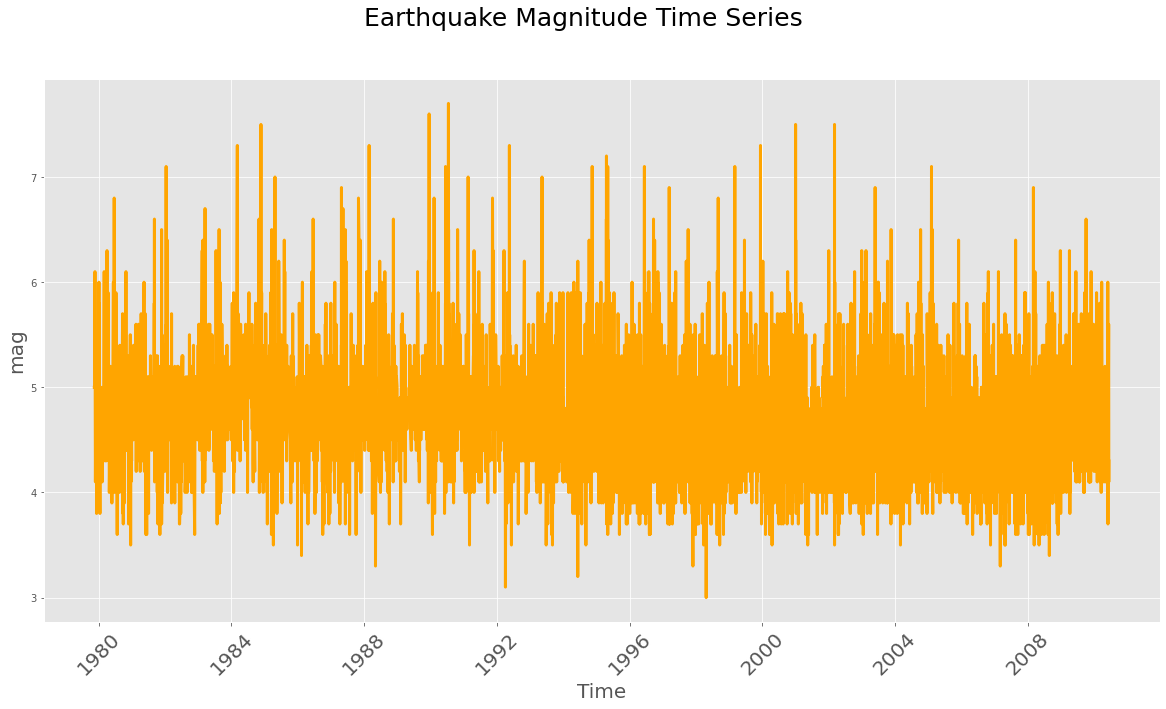

In [35]:
# Look at the whole Magnitude time series
tsplot(df1, var='mag', period='all')

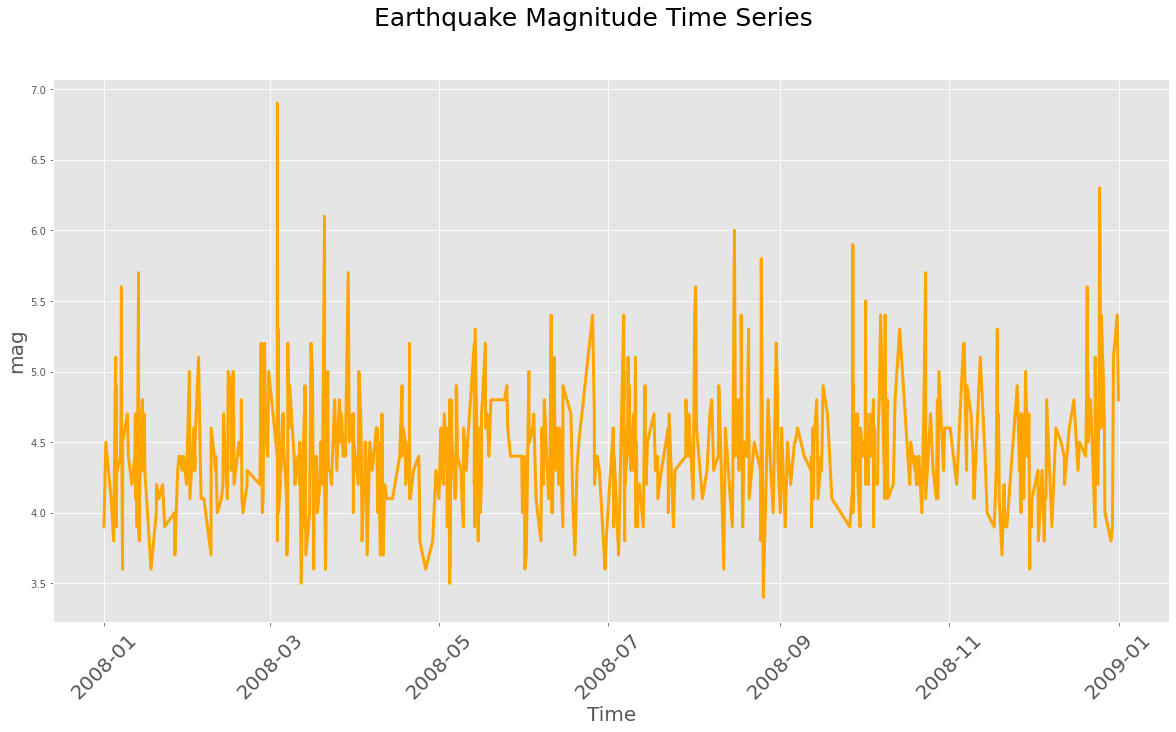

In [36]:
# Look at the single magnitude year
tsplot(df1,var='mag', period='2008')

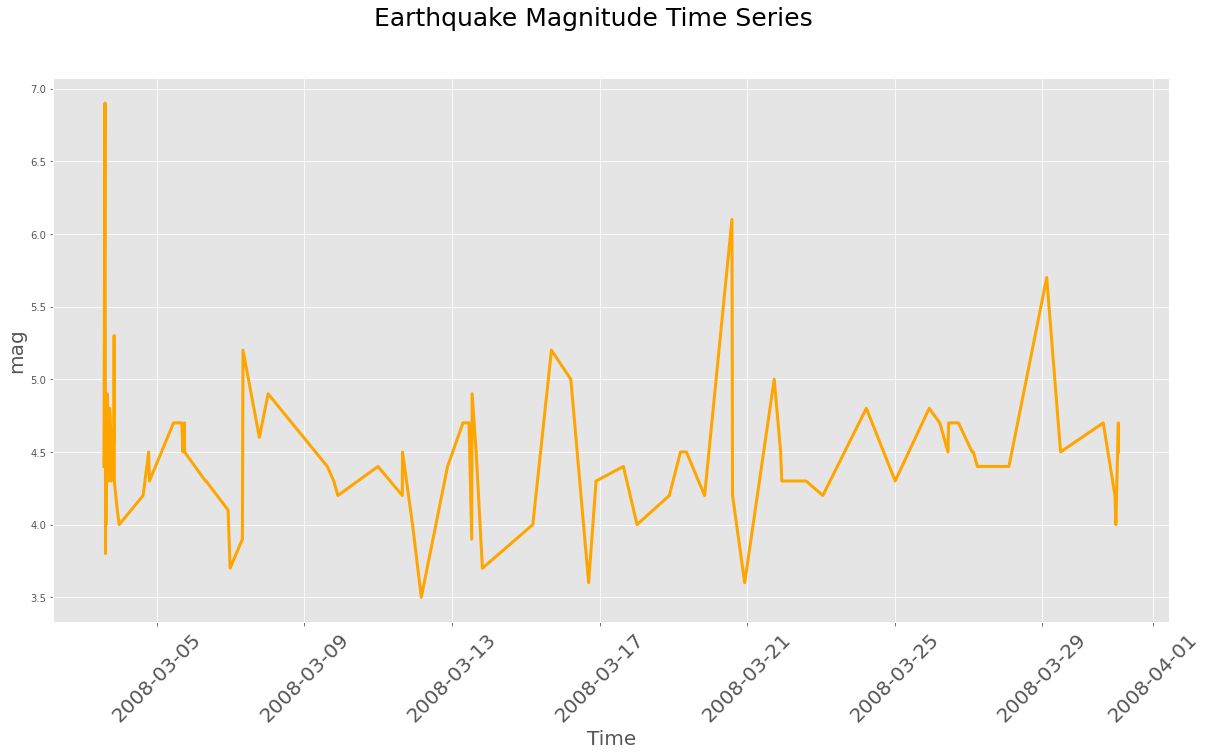

In [37]:
# Look at the single magnitude year-month
tsplot(df1,var='mag', period='2008-03')

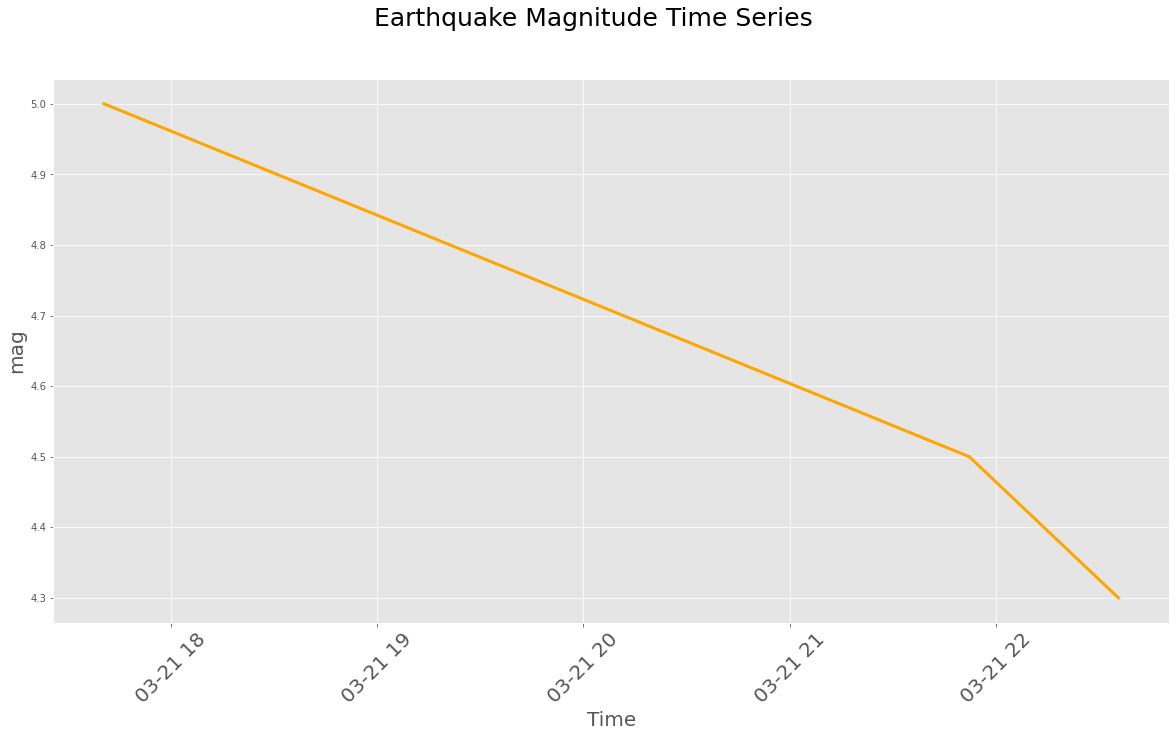

In [38]:
# Look at the single magnitude year-month-day
tsplot(df1,var='mag', period='2008-03-21')

Earthquake Magnitude per place


,place,mag,PERCENTAGE
0,"Luzon, Philippines",7.700000,4.833647
1,"Mindanao, Philippines",7.600000,4.770873
2,"Catanduanes, Philippines",7.300000,4.582549
3,"Samar, Philippines",7.200000,4.519774
4,"Mindoro, Philippines",7.100000,4.456999
5,Celebes Sea,7.100000,4.456999
6,"Panay, Philippines",7.100000,4.456999
7,"Sulu Archipelago, Philippines",7.100000,4.456999
8,"Moro Gulf, Mindanao, Philippines",6.900000,4.331450
9,Philippine Islands region,6.900000,4.331450


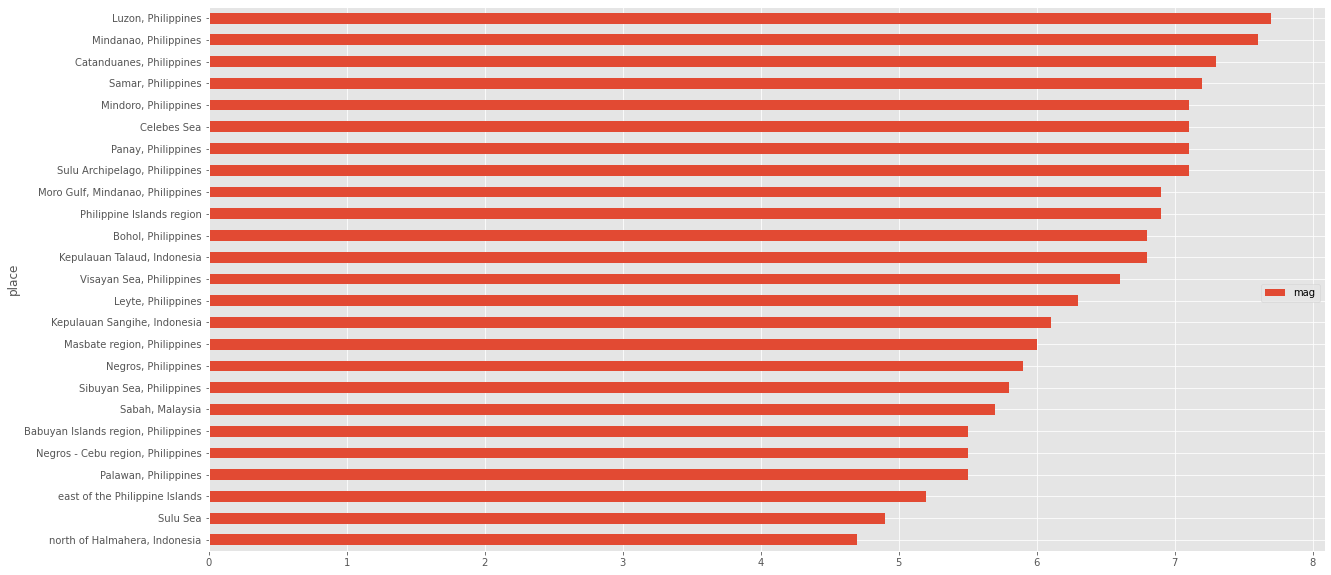

In [39]:
# query and barplot
variable = 'place'
print('Earthquake Magnitude per {}'.format(variable))
query(df1, col='place')

In [40]:
fig=px.density_mapbox(df1, lat='latitude',lon='longitude',radius=1,
                    zoom=3.5, mapbox_style='stamen-terrain',center=dict(lat=11,lon=125),
                      title='Earthquake Magnitude Geographical Distribution')
fig.show()


### Decomposition

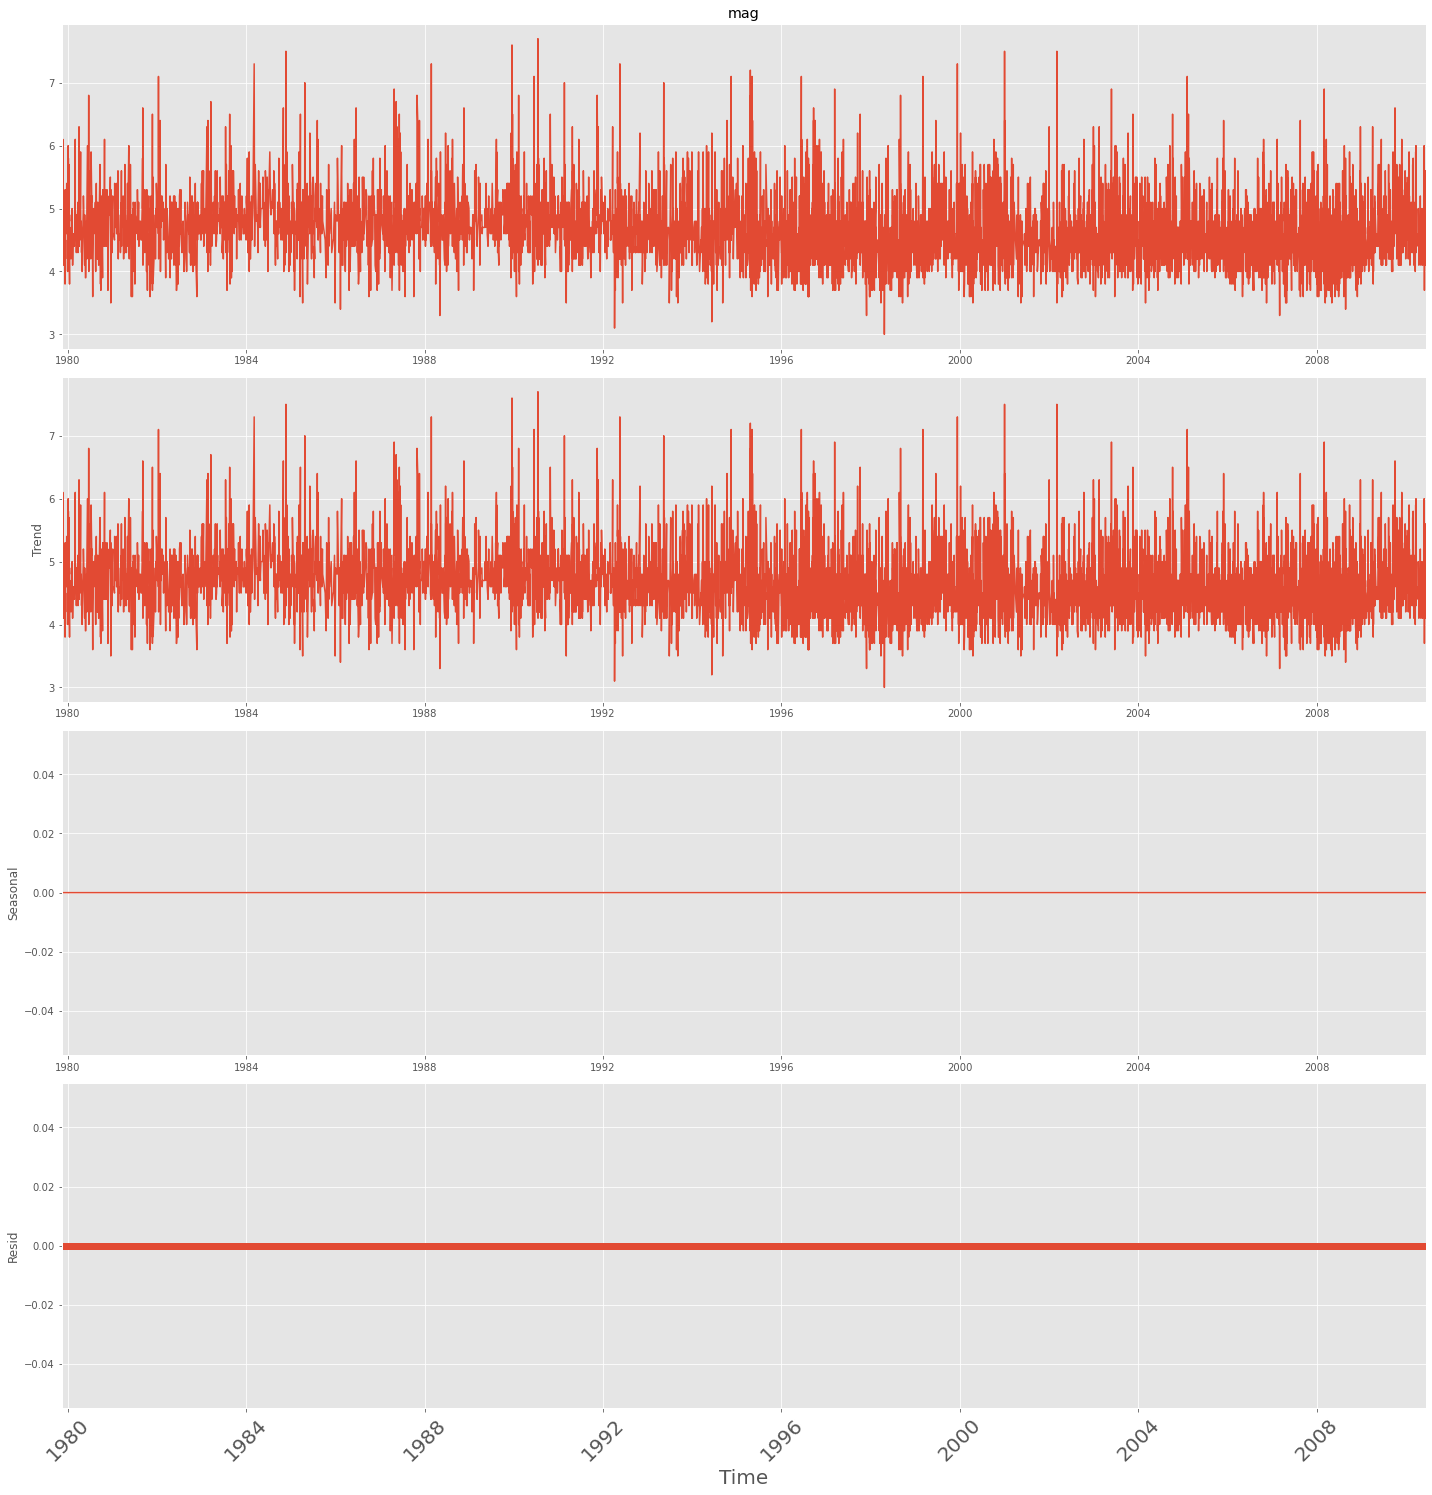

In [41]:
# Additive Decomposition
add_res = seasonal_decompose(x=df1['mag'], model="additive", period=1)
plt.rcParams['figure.figsize']=(20,20)
add_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

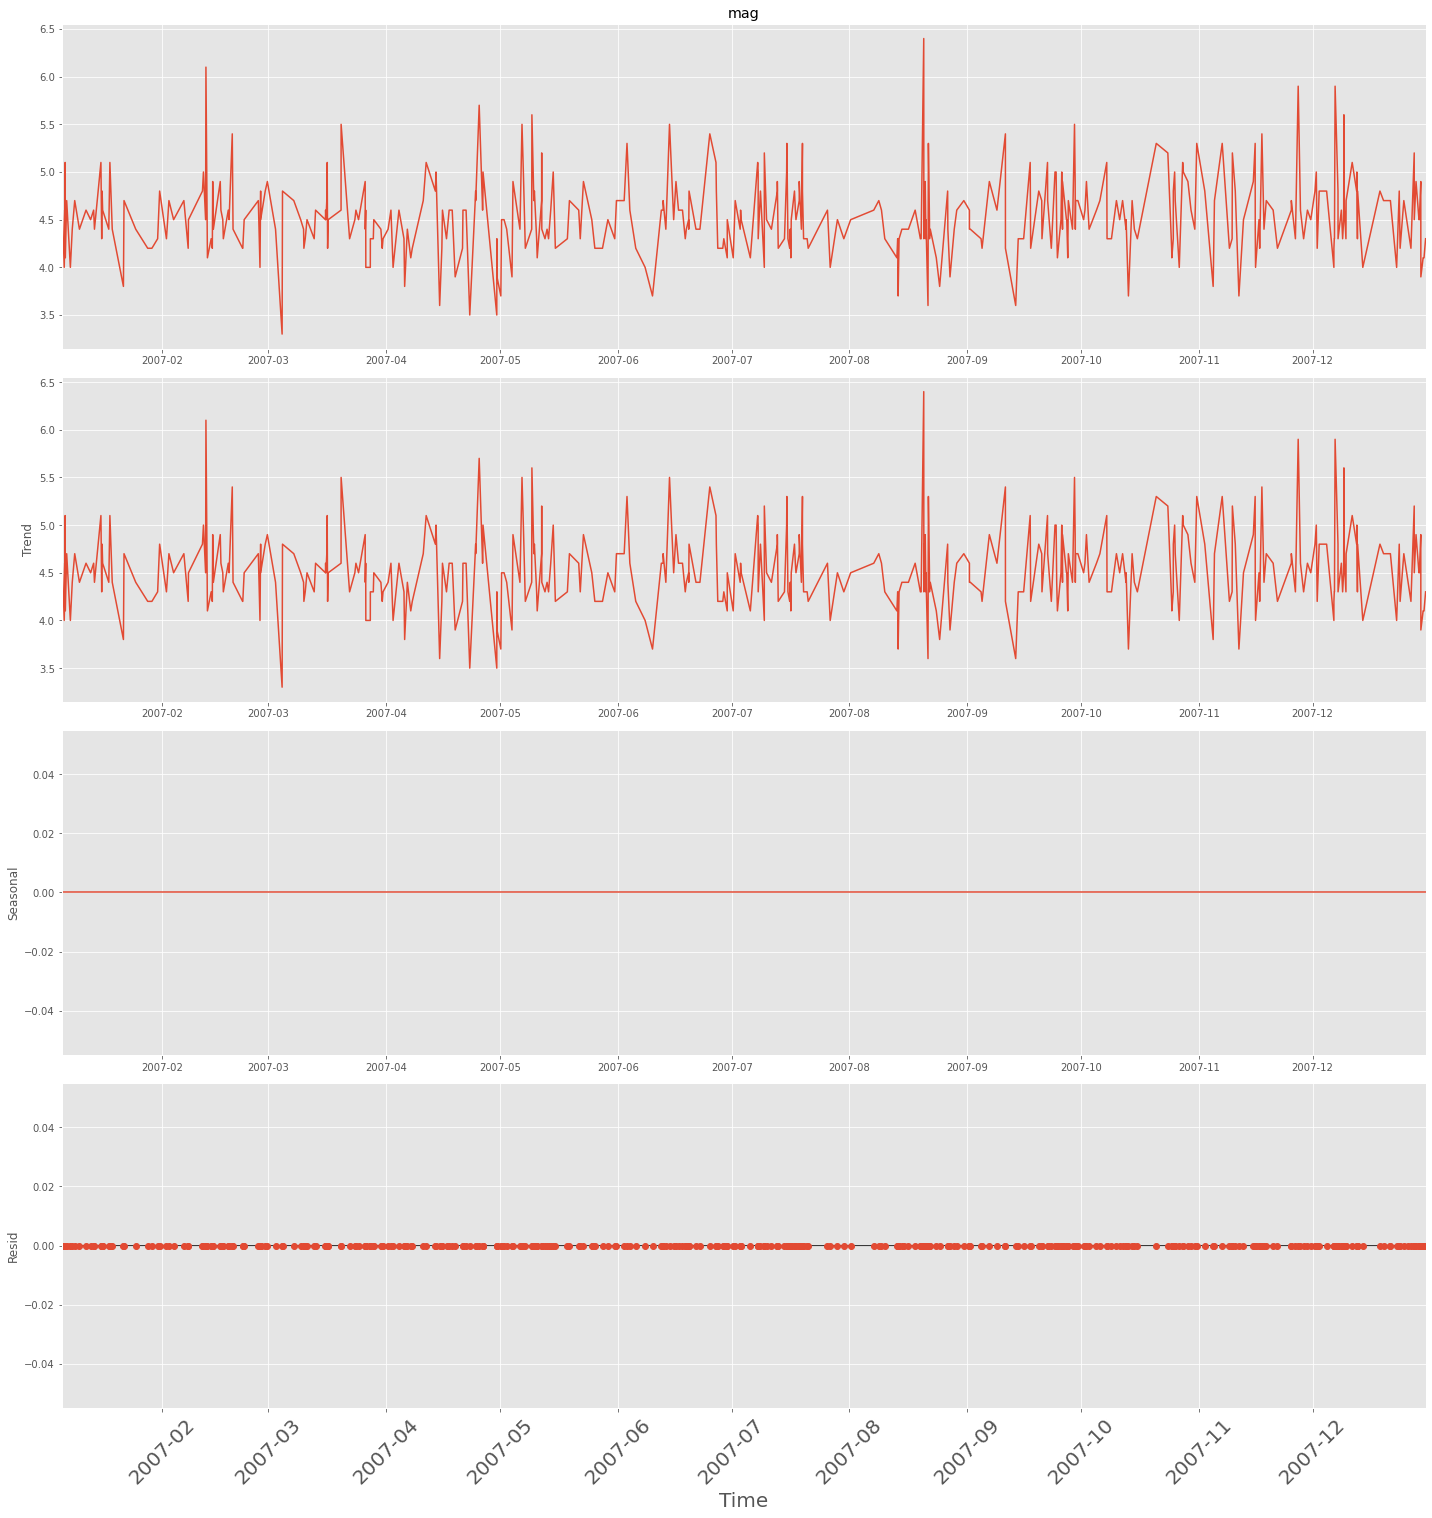

In [42]:
# Additive Decomposition year
add_res_2007 = seasonal_decompose(x=df1['mag'].loc['2007'], model="additive", period=1)
plt.rcParams['figure.figsize']=(20,20)
add_res_2007.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

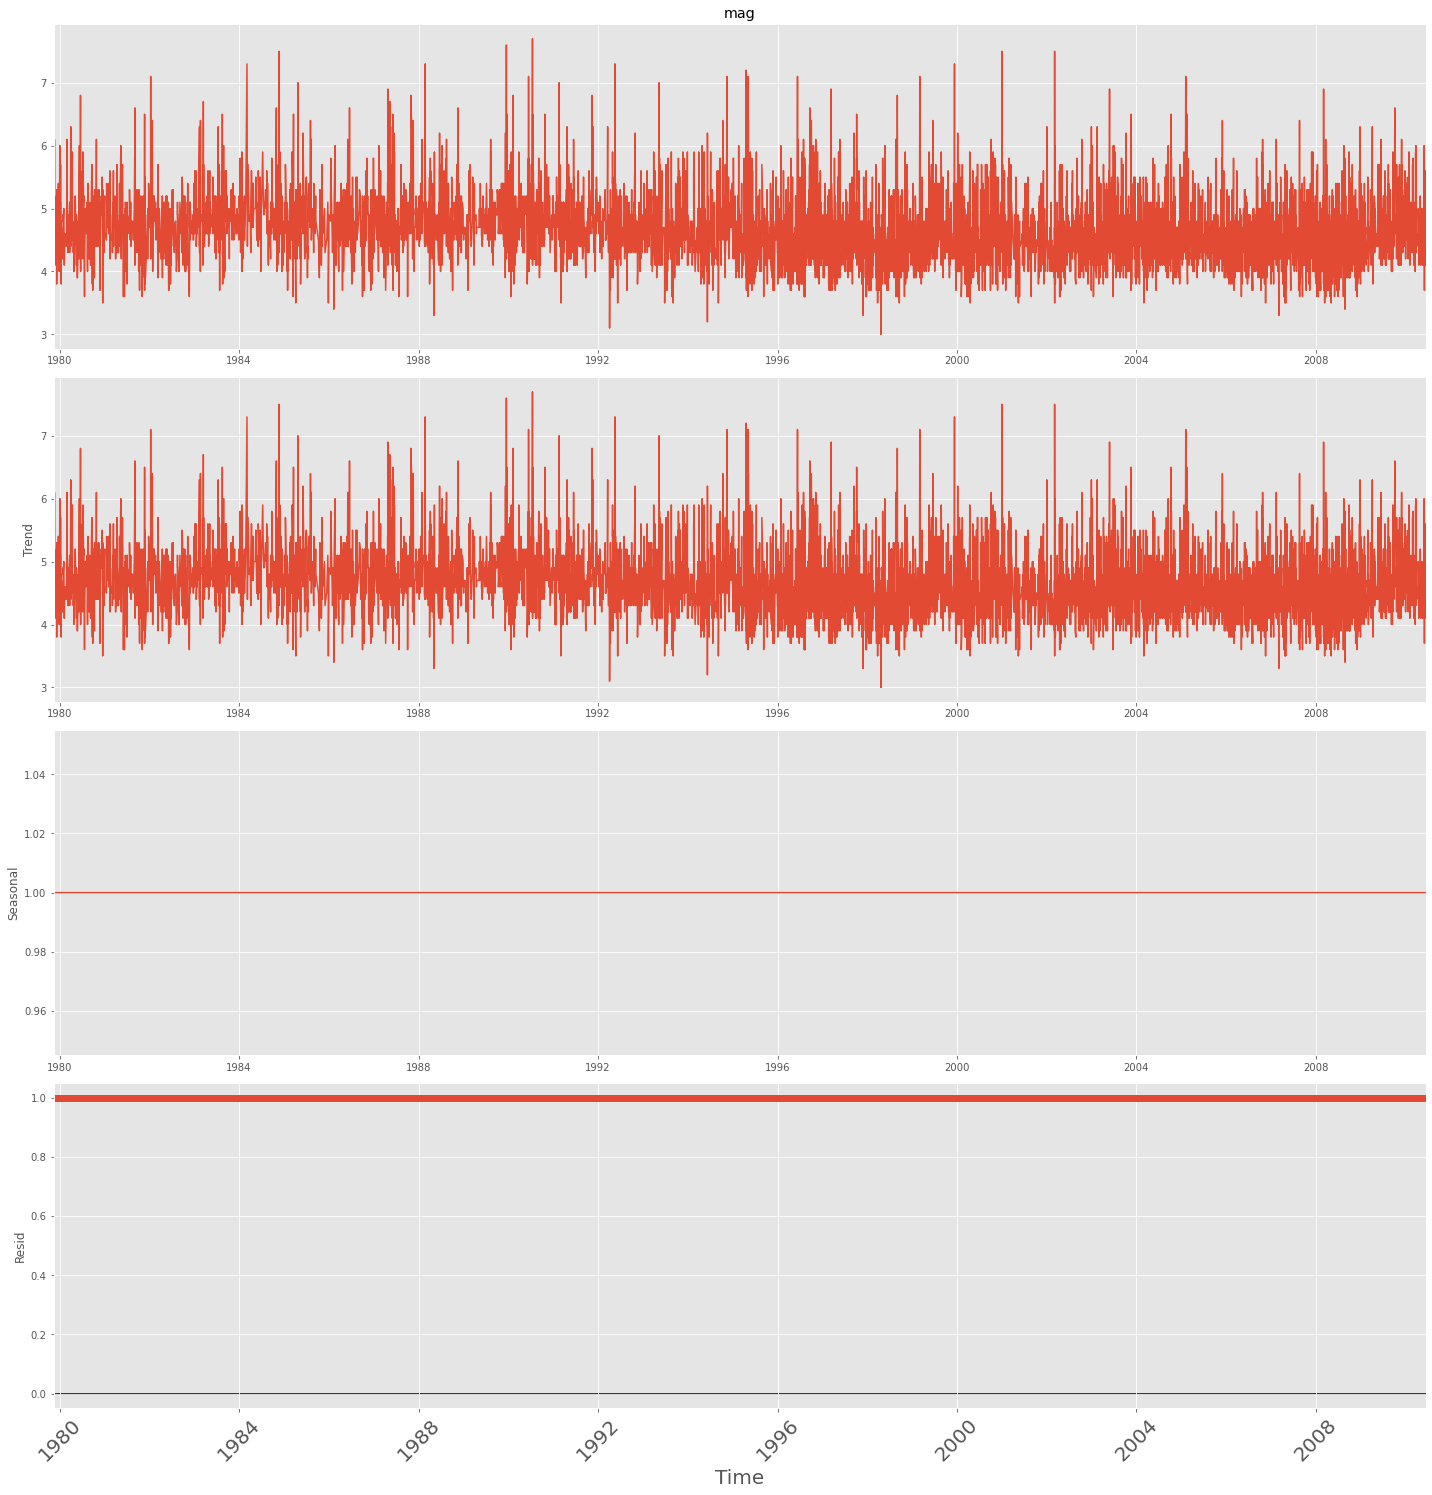

In [43]:
# Multiplicative Decomposition
mul_res = seasonal_decompose(x=df1['mag'], model="multiplicative", period=1)
plt.rcParams['figure.figsize']=(20,20)
mul_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

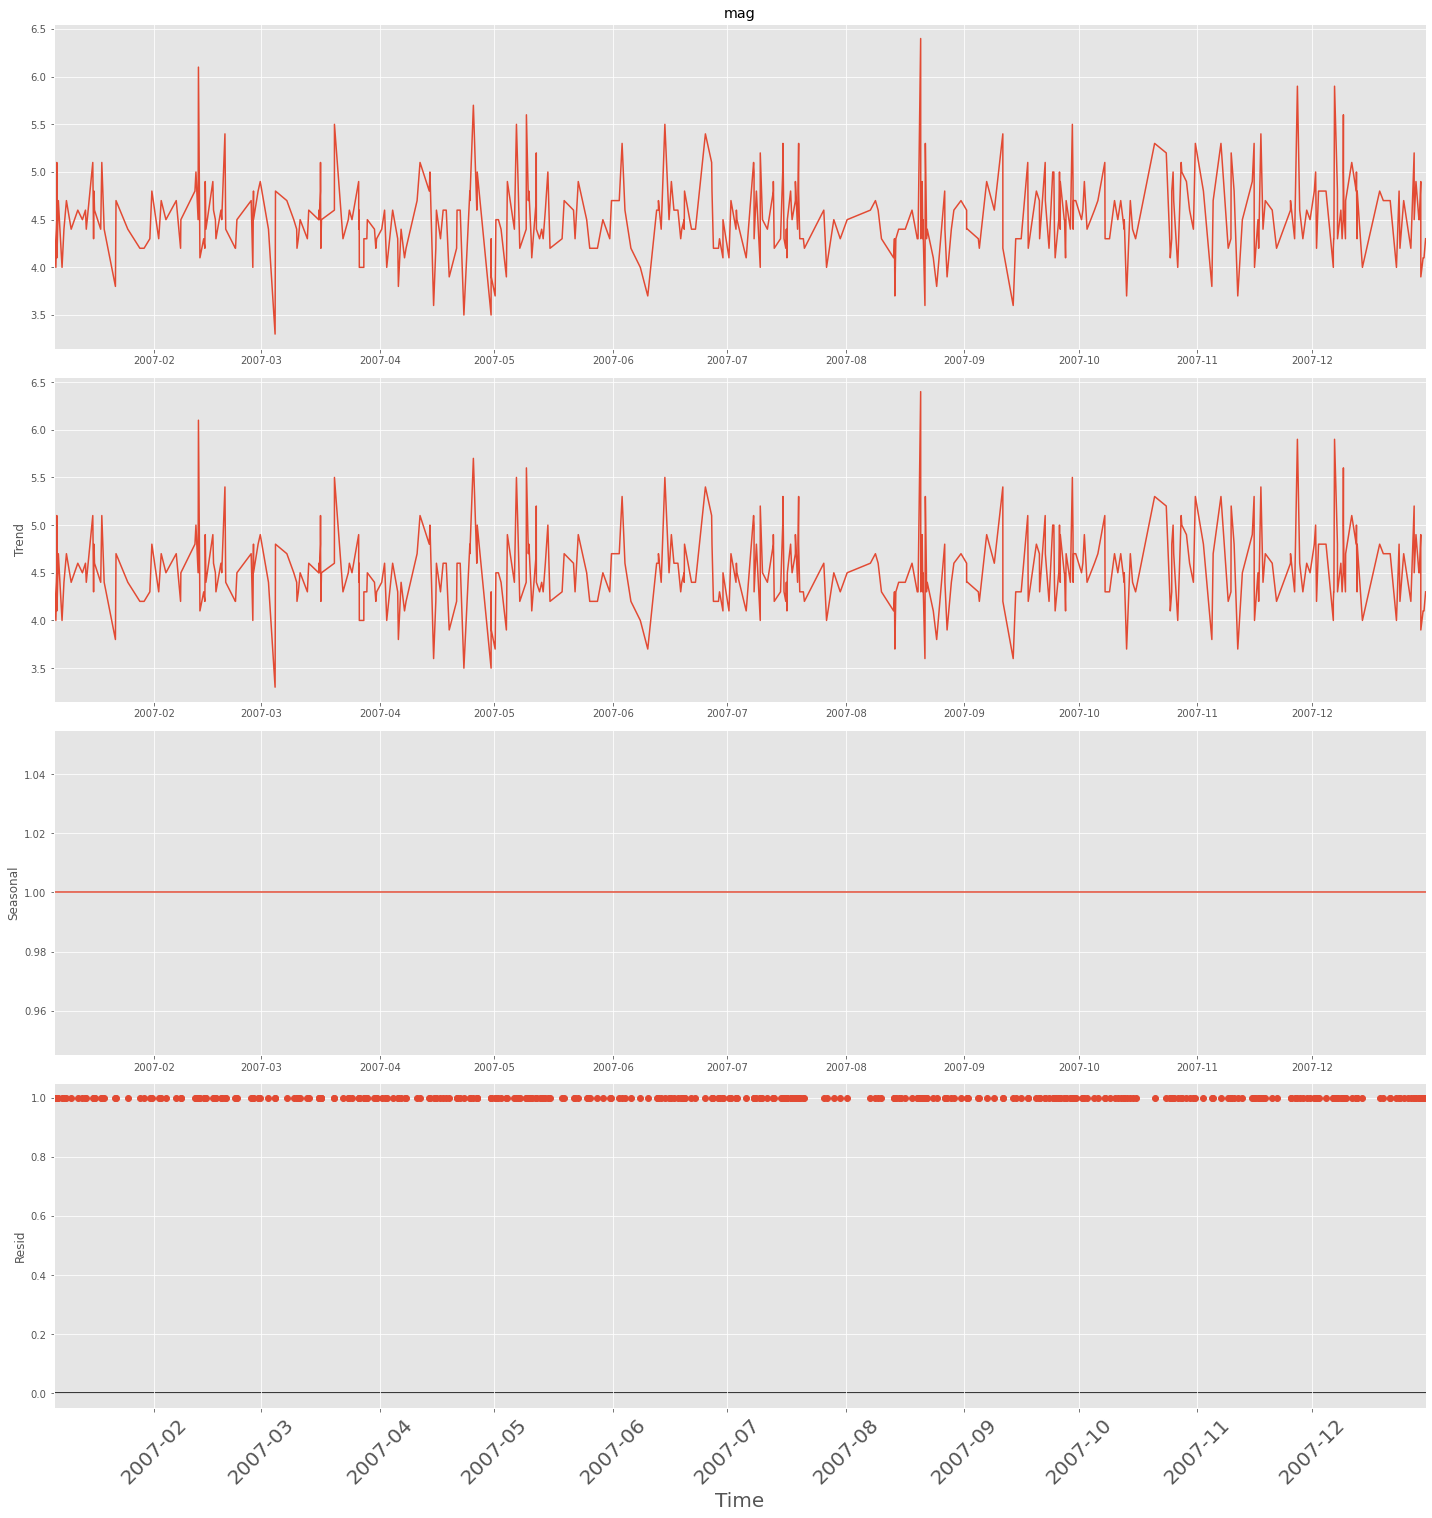

In [44]:
# Multiplicative Decomposition year
mul_res_2007 = seasonal_decompose(x=df1['mag'].loc['2007'], model="multiplicative", period=1)
plt.rcParams['figure.figsize']=(20,20)
mul_res_2007.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

### Rolling window statistics

In [45]:
# Create window features for rolling window
transformer = WindowFeatures(
    variables=["mag"],
    functions=["mean", "std"],
    window=[1,7,30,365], # Day, week, month, year.
)

df2 = transformer.fit_transform(df1)

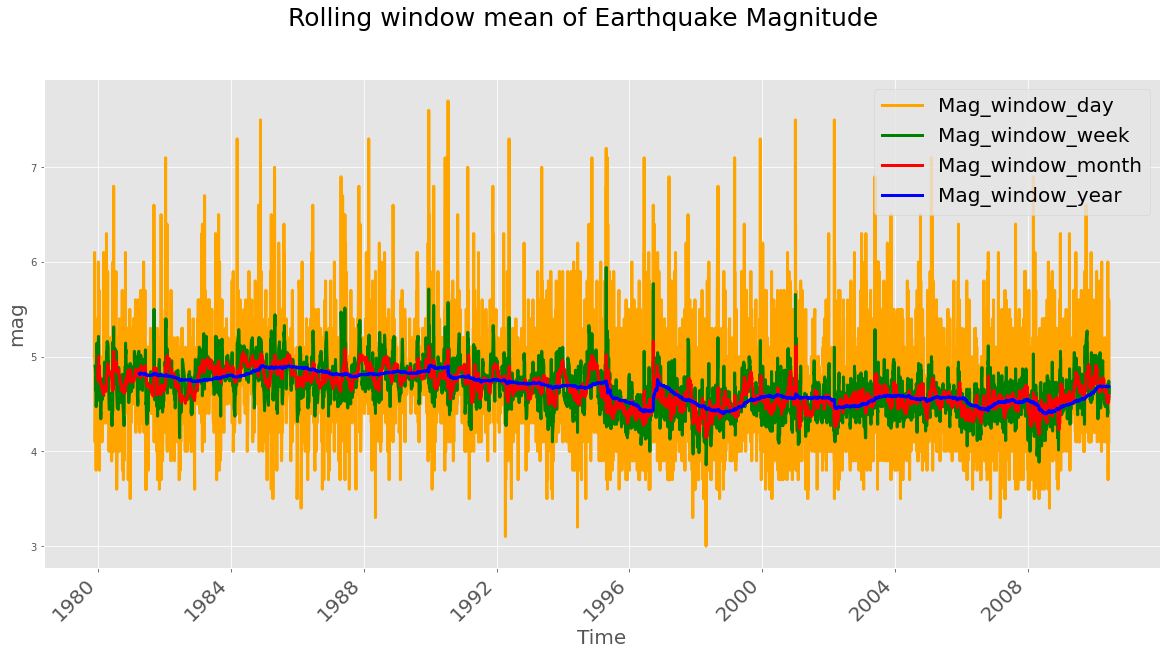

In [46]:
# Plot time series with mean rolling window for day, week month and year 
colors = ['orange', 'green', 'red', 'blue']
df2.filter(
    regex="mag_.*?_mean", # `.*?` means any number of any characters.
    axis=1  # Filter by column names.
).plot(color=colors, linewidth=3,figsize=(20,10))
my_labels=['Mag_window_day', 'Mag_window_week','Mag_window_month','Mag_window_year']
plt.suptitle("Rolling window mean of Earthquake Magnitude",fontsize=25)
plt.xlabel('Time', fontsize=20)
plt.ylabel('mag', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.legend(my_labels,fontsize=20)
plt.show()

### Stationarity

In [47]:
#  statistics of partitioned time series 
X = df1['mag'].values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=4.736455, mean2=4.525049
variance1=0.227735, variance2=0.195694


In [48]:
#  statistics of log partitioned time series
X = df1['mag'].values
X = np.log1p(X)
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1.743519, mean2=1.706226
variance1=0.006536, variance2=0.006015


In [49]:
# Augmented Dickey-Fuller test
X = df1['mag'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.185504
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [50]:
# Split data set between target variable and features
X_full = df1.copy()
y = X_full.mag
X_full.drop(['mag'], axis=1, inplace=True)
# Drop useless features
X_full.drop(['type','year','month','day','hour'], axis=1, inplace=True)

In [51]:
# https://infopython.com/how-to-plot-longitude-and-latitude-data-in-python/

### Categorical features analysis

In [52]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

magType :  5  labels
place :  25  labels
magSource :  4  labels


In [53]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [var for var in X_full.columns if
                    X_full[var].nunique() <= 15 and 
                    X_full[var].dtype == "object"]

In [54]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns

Index(['magType', 'magSource'], dtype='object')

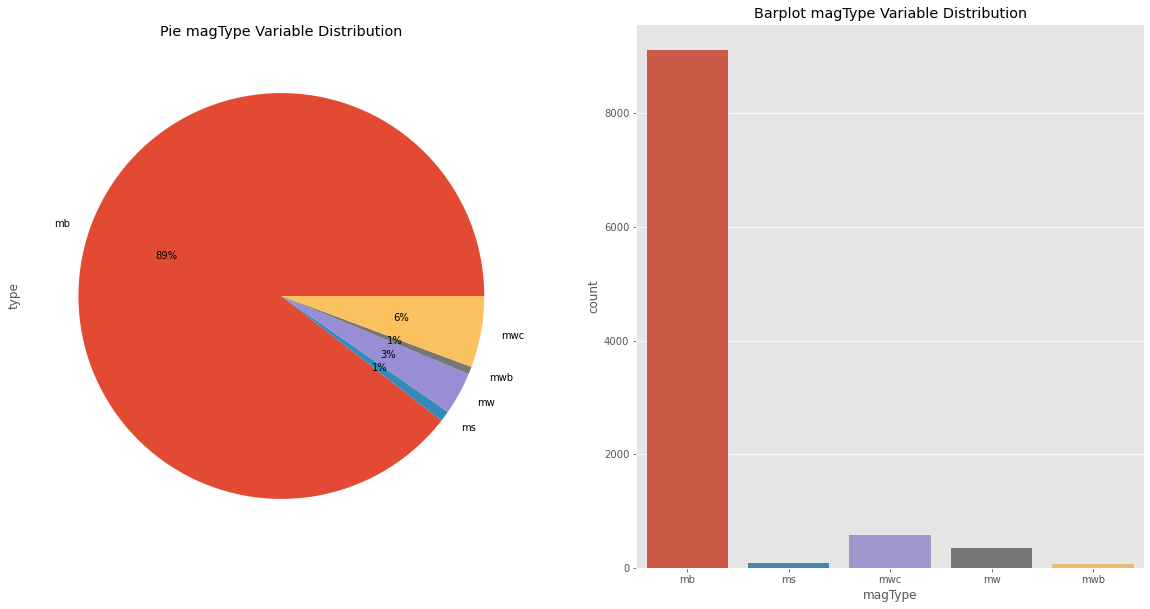

In [55]:
piechart(df, col1='magType', col2='type')

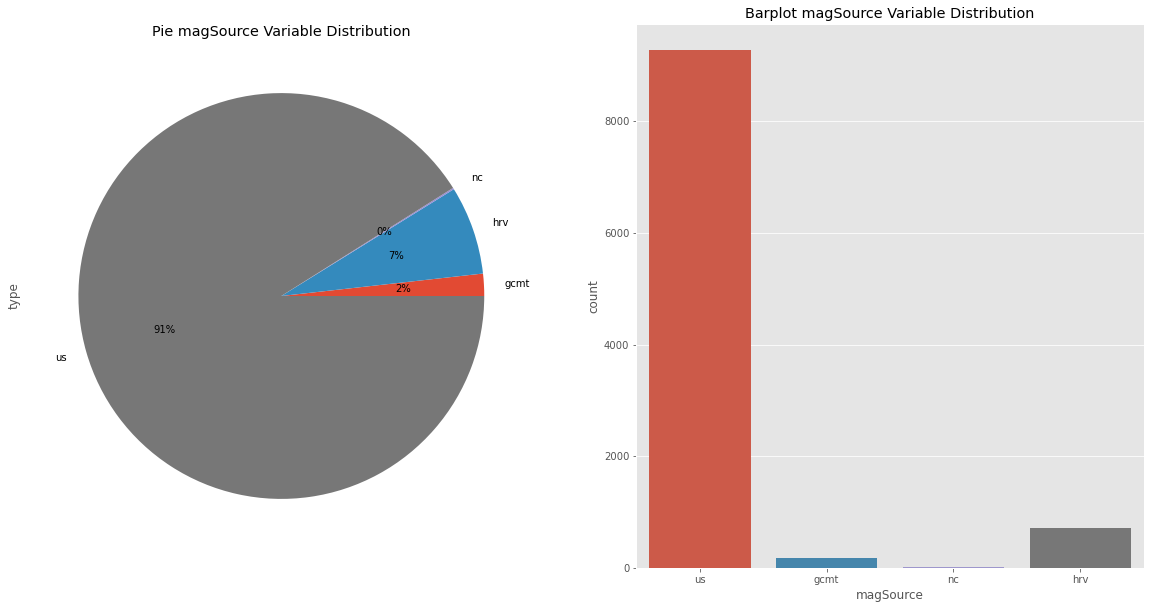

In [56]:
piechart(df, col1='magSource', col2='type')

In [57]:
# Univariate analysis looking at frequency
for col in cat:
    count = pd.crosstab(index = cat[col], columns="count")
    percentage = pd.crosstab(index = cat[col], columns="frequency")/pd.crosstab(index = cat[col], columns="frequency").sum()
    tab = pd.concat([count, percentage], axis=1)
    print('\n',tab)


 col_0    count  frequency
magType                  
mb        9116   0.894778
ms          86   0.008441
mw         346   0.033962
mwb         61   0.005987
mwc        579   0.056832

 col_0      count  frequency
magSource                  
gcmt         180   0.017668
hrv          719   0.070573
nc            12   0.001178
us          9277   0.910581


### Numerical features analysis

In [58]:
# Select numerical columns
numerical_cols = [var for var in X_full.columns if X_full[var].dtype in ['float64','int64']]

In [59]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['latitude', 'longitude', 'depth'], dtype='object')

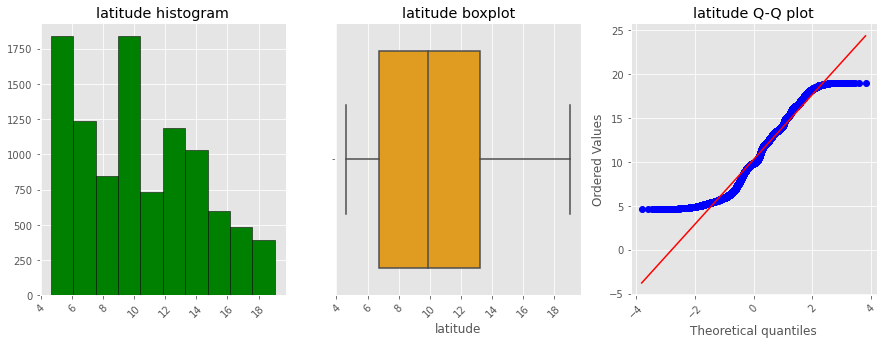

In [60]:
plot_num(num, var='latitude')

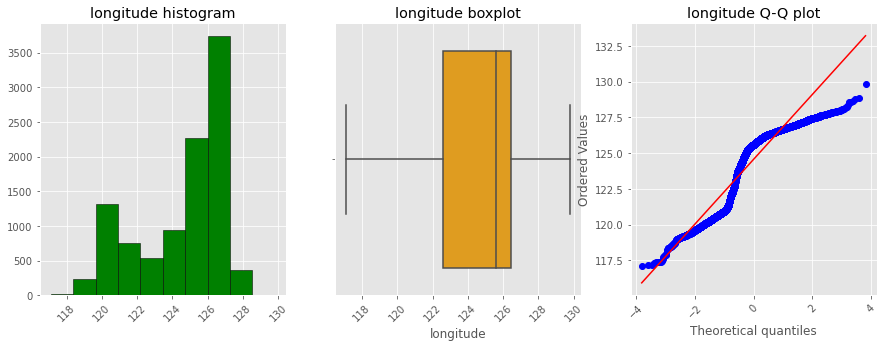

In [61]:
plot_num(num, var='longitude')

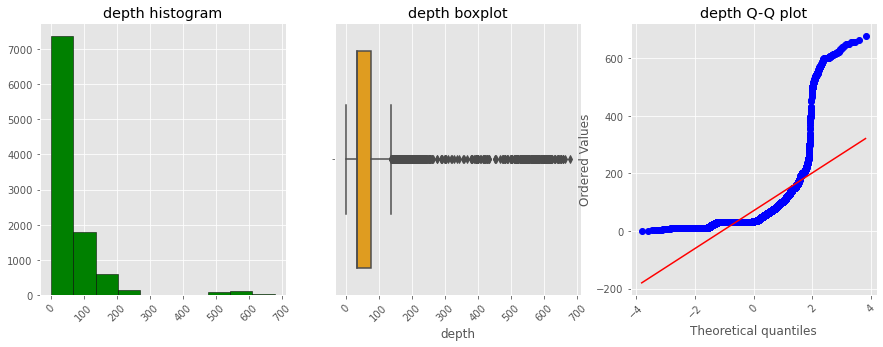

In [62]:
plot_num(num, var='depth')

### Feature engineering for Lag features and Categorical features

In [63]:
# Lag features
df_lag = pd.concat(
    [
        y,
        y.shift(1).rename("lag_1"),
        y.shift(2).rename("lag_2"),
        y.shift(3).rename("lag_3"),
        num,
        cat
    ],
    axis="columns",
)

In [64]:
# Remove nan values
df_lag = df_lag.dropna()

In [65]:
# Filter data frmae with homogeneous magnitude type
df3=df_lag[df_lag['magType']=='mb']
df4 = df3.drop(['magType'], axis=1)

In [66]:
# Mean encoding
enc = MeanEncoder()
y = df4['mag']
X = df4.drop(['mag'], axis=1)
enc.fit(X, y)
X_t = enc.transform(X)

### Split data set & pre-processing

In [67]:
# Test set on 1 year (223 values)
split_point = '2009-06-12'
X_train, X_test = X_t[X_t.index<split_point], X_t[X_t.index>=split_point]
y_train, y_test = y[y.index<split_point], y[y.index>=split_point]
len(X_train), len(X_test)

(8890, 223)

In [68]:
# Split for time series cross validation
ts_cv = TimeSeriesSplit(n_splits=5)
# splits
splits = list(ts_cv.split(X_t, y))

In [69]:
scaling = MinMaxScaler()

In [70]:
# Scaled features for KNN 
X_sc= pd.DataFrame(scaling.fit_transform(X_t),columns= ['lag_1','lag_2','lag_3','latitude','longitude','depth','magSource'])
X_train_sc= pd.DataFrame(scaling.fit_transform(X_train),columns= ['lag_1','lag_2','lag_3','latitude','longitude','depth','magSource'])
X_test_sc= pd.DataFrame(scaling.fit_transform(X_test),columns= ['lag_1','lag_2','lag_3','latitude','longitude','depth','magSource'])
y_sc = scaling.fit_transform(pd.DataFrame(y).values.reshape(-1,1))
y_train_sc = scaling.fit_transform(pd.DataFrame(y_train).values.reshape(-1,1))
y_test_sc = scaling.fit_transform(pd.DataFrame(y_test).values.reshape(-1,1))

### K-Nearest Neighbours

In [71]:
# Evaluation following quantile approach
KNN = KNeighborsRegressor()
param_grid = {}
KNN_model = GridSearchCV(KNN,param_grid,cv=ts_cv)
KNN_model.fit(X_train_sc, np.log1p(y_train_sc))
knn_mean = KNN_model.predict(X_test_sc)
qKNN = KNeighborsQuantileRegressor(q=[0.05, 0.5, 0.95])
param_grid = {}
qKNN_model = GridSearchCV(qKNN,param_grid,cv=ts_cv)
qKNN_model.fit(X_train_sc, np.log1p(y_train_sc))
qKNN_pred = qKNN_model.predict(X_test_sc)
qknn_lower = qKNN_pred[0,:,0]
qknn_median = qKNN_pred[1,:,0]
qknn_upper = qKNN_pred[2,:,0]

In [72]:
print('Test evaluation')
rmse_knn_mean = np.sqrt(mean_squared_error(np.log1p(y_test_sc), knn_mean))
print(f"root_mean_squared_error_knn_mean: {rmse_knn_mean:.3f}")
rmse_qknn_lower = np.sqrt(mean_squared_error(np.log1p(y_test_sc), qknn_lower))
print(f"root_mean_squared_error_qknn_lower: {rmse_qknn_lower:.3f}")
rmse_qknn_median = np.sqrt(mean_squared_error(np.log1p(y_test_sc), qknn_median))
print(f"root_mean_squared_error_qknn_median: {rmse_qknn_median:.3f}")
rmse_qknn_upper = np.sqrt(mean_squared_error(np.log1p(y_test_sc), qknn_upper))
print(f"root_mean_squared_error_qknn_upper: {rmse_qknn_upper:.3f}")


Test evaluation
root_mean_squared_error_knn_mean: 0.112
root_mean_squared_error_qknn_lower: 0.127
root_mean_squared_error_qknn_median: 0.115
root_mean_squared_error_qknn_upper: 0.153


In [73]:
# Transformations
qknn_lower_ = scaling.inverse_transform(np.expm1(qknn_lower).reshape(-1,1))
qknn_median_ = scaling.inverse_transform(np.expm1(qknn_median).reshape(-1,1))
qknn_upper_ = scaling.inverse_transform(np.expm1(qknn_upper).reshape(-1,1))

In [74]:
# 5 Percentile
(qknn_lower_ > y_test.values).mean()

0.3353174204186692

In [75]:
# Median percentile
(qknn_median_ > y_test.values).mean()

0.6081562066399887

In [76]:
# 95 percentile
(qknn_upper_ > y_test.values).mean()

0.8347443141828712

In [77]:
# Coverage
np.logical_and(
    qknn_lower_ < y_test.values,
    qknn_upper_ > y_test.values,
).mean()

0.49942689376420196

In [78]:
# Features Importance
print('KNN Features Permutation Importance')
KNN_perm = PermutationImportance(KNN_model, random_state=0).fit(X_test_sc, np.log1p(y_test_sc))
eli5.show_weights(KNN_perm, feature_names = X_test.columns.tolist())

KNN Features Permutation Importance


Weight,Feature
0.0570 ± 0.0923,lag_1
0.0530 ± 0.0860,lag_3
0.0513 ± 0.0457,depth
0.0318 ± 0.0395,lag_2
0.0158 ± 0.0787,latitude
0 ± 0.0000,magSource
-0.0132 ± 0.0374,longitude


Partial dependence of Earthquake Magnitude on features with KNN model


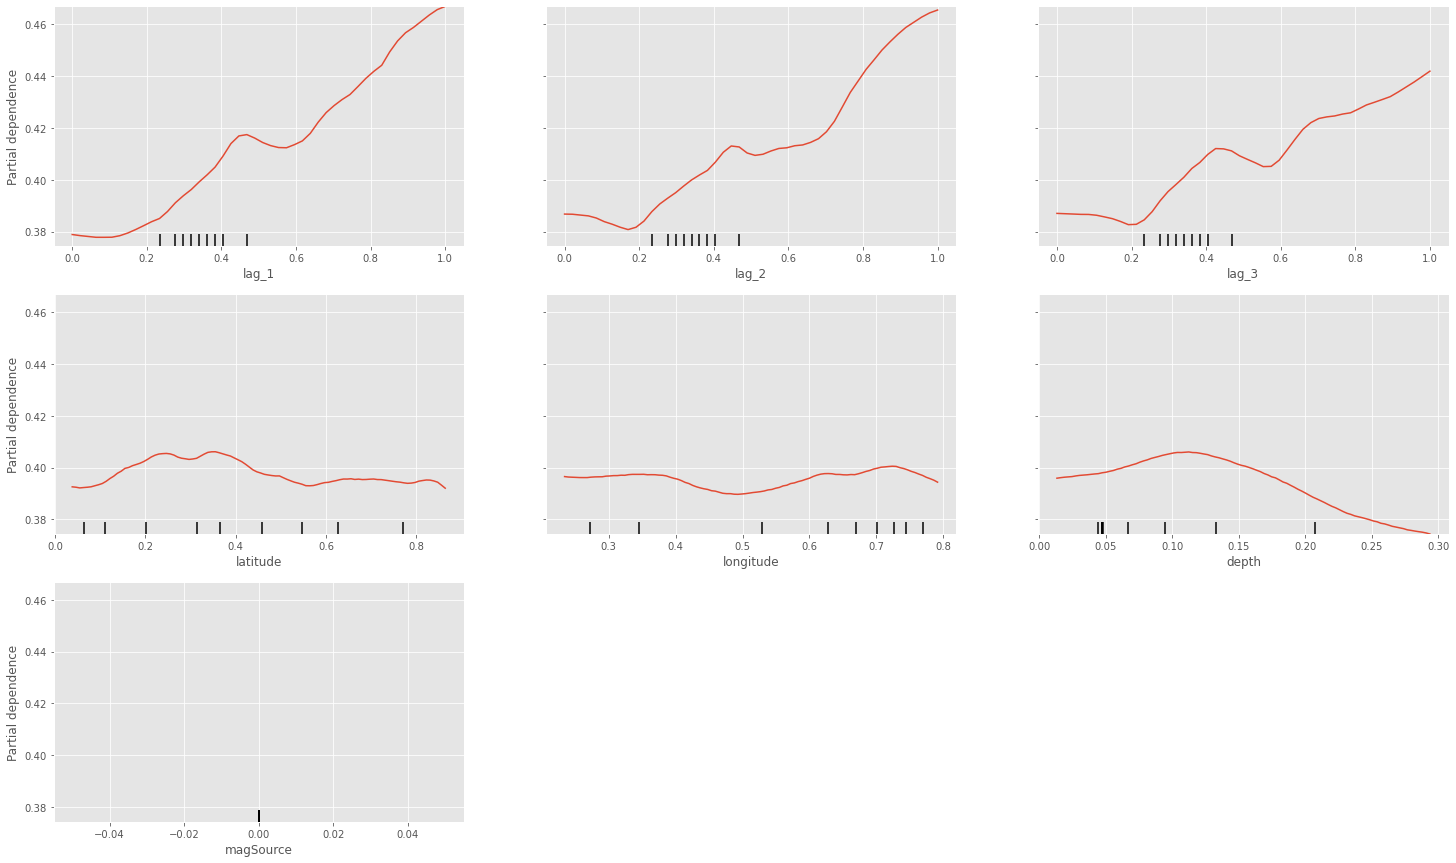

In [79]:
# Partial Dependence Plot
plt.rcParams['figure.figsize']=(25,15)
PartialDependenceDisplay.from_estimator(KNN_model,X_sc,
['lag_1','lag_2','lag_3','latitude','longitude','depth','magSource'], 
                                        kind='average', random_state=0)
print("Partial dependence of Earthquake Magnitude on features with KNN model")
plt.show()

### Random forest

In [80]:
# Evaluation following quantile approach
RF = RandomForestRegressor(random_state=0)
param_grid = {}
RF_model = GridSearchCV(RF,param_grid,cv=ts_cv)
RF_model.fit(X_train, np.log1p(y_train))
rf_mean = RF_model.predict(X_test)
qRF = RandomForestQuantileRegressor(q=[0.05, 0.5, 0.95],random_state=0)
param_grid = {}
qRF_model = GridSearchCV(qRF,param_grid,cv=ts_cv)
qRF_model.fit(X_train, np.log1p(y_train))
qRF_pred = qRF_model.predict(X_test)
qRF_lower = qRF_pred[0,:]
qRF_median = qRF_pred[1,:]
qRF_upper = qRF_pred[2,:]

In [81]:
print('Test evaluation')
rmse_rf_mean = np.sqrt(mean_squared_error(np.log1p(y_test), rf_mean))
print(f"root_mean_squared_error_rf_mean: {rmse_rf_mean:.3f}")
rmse_qrf_lower = np.sqrt(mean_squared_error(np.log1p(y_test), qRF_lower))
print(f"root_mean_squared_error_qrf_lower: {rmse_qrf_lower:.3f}")
rmse_qrf_median = np.sqrt(mean_squared_error(np.log1p(y_test), qRF_median))
print(f"root_mean_squared_error_qrf_median: {rmse_qrf_median:.3f}")
rmse_qrf_upper = np.sqrt(mean_squared_error(np.log1p(y_test), qRF_upper))
print(f"root_mean_squared_error_qrf_upper: {rmse_qrf_upper:.3f}")


Test evaluation
root_mean_squared_error_rf_mean: 0.051
root_mean_squared_error_qrf_lower: 0.116
root_mean_squared_error_qrf_median: 0.057
root_mean_squared_error_qrf_upper: 0.112


In [82]:
# Transformations
qRF_lower_ = np.expm1(qRF_lower).reshape(-1,1)
qRF_median_ = np.expm1(qRF_median).reshape(-1,1)
qRF_upper_ = np.expm1(qRF_upper).reshape(-1,1)

In [83]:
# 5 Percentile
(qRF_lower_ > y_test.values).mean()

0.08592571738824428

In [84]:
# Median percentile
(qRF_median_ > y_test.values).mean()

0.573870377445756

In [85]:
# 95 percentile
(qRF_upper_ > y_test.values).mean()

0.9259788051237708

In [86]:
# Coverage
np.logical_and(
    qRF_lower_ < y_test.values,
    qRF_upper_ > y_test.values,
).mean()

0.8381829515976593

In [87]:
# Features Importance
print('RF Features Permutation Importance')
RF_perm = PermutationImportance(RF_model, random_state=0).fit(X_test, np.log1p(y_test))
eli5.show_weights(RF_perm, feature_names = X_test.columns.tolist())

RF Features Permutation Importance


Weight,Feature
0.1094 ± 0.0305,depth
0.0229 ± 0.0616,lag_2
0.0121 ± 0.0572,latitude
0.0093 ± 0.0472,longitude
0 ± 0.0000,magSource
-0.0011 ± 0.0787,lag_3
-0.0202 ± 0.0897,lag_1


Partial dependence of Earthquake Magnitude on features with RF model


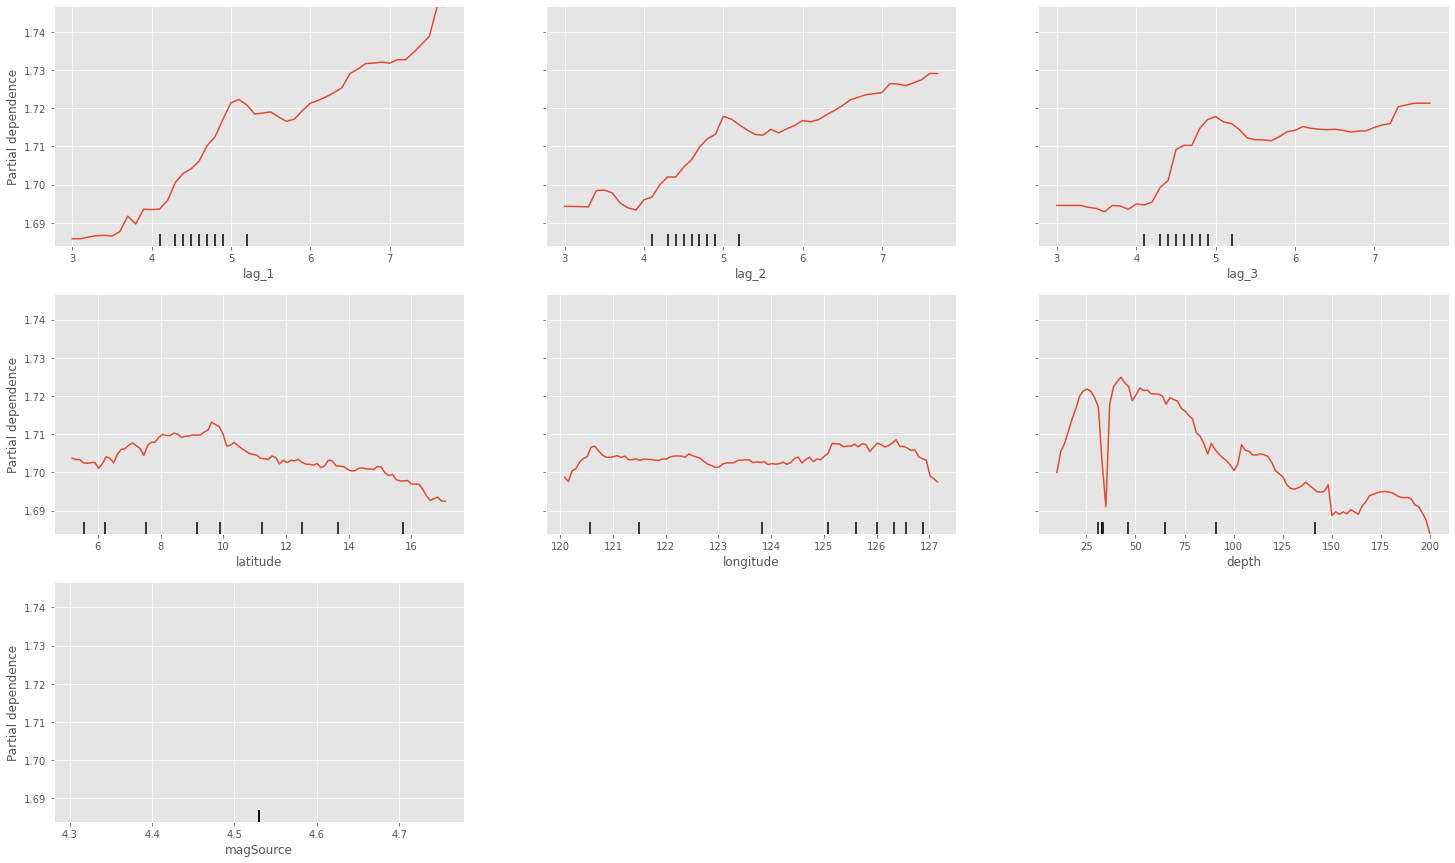

In [88]:
# Partial Dependence Plot
plt.rcParams['figure.figsize']=(25,15)
PartialDependenceDisplay.from_estimator(RF_model,X_t,
['lag_1','lag_2','lag_3','latitude','longitude','depth','magSource'], 
                                        kind='average', random_state=0)
print("Partial dependence of Earthquake Magnitude on features with RF model")
plt.show()

### Gradient Boosting Machine

In [89]:
# Evaluation following quantile approach
GBM = GradientBoostingRegressor(random_state=0)
param_grid = {}
GBM_model = GridSearchCV(GBM,param_grid,cv=ts_cv)
GBM_model.fit(X_train, np.log1p(y_train))
gbm_mean = GBM_model.predict(X_test)

qGBM = GradientBoostingRegressor(loss="quantile", alpha=0.05, random_state=0)
param_grid = {}
qGBM_model = GridSearchCV(qGBM,param_grid,cv=ts_cv)
qGBM_model.fit(X_train, np.log1p(y_train))
qGBM_lower = qGBM_model.predict(X_test)

qGBM = GradientBoostingRegressor(loss="quantile",alpha=0.5, random_state=0)
param_grid = {}
qGBM_model = GridSearchCV(qGBM,param_grid,cv=ts_cv)
qGBM_model.fit(X_train, np.log1p(y_train))
qGBM_median = qGBM_model.predict(X_test)

qGBM = GradientBoostingRegressor(loss='quantile', alpha=0.95,random_state=0)
param_grid = {}
qGBM_model = GridSearchCV(qGBM,param_grid,cv=ts_cv)
qGBM_model.fit(X_train, np.log1p(y_train))
qGBM_upper = qGBM_model.predict(X_test)



In [90]:
print('Test evaluation')
rmse_gbm_mean = np.sqrt(mean_squared_error(np.log1p(y_test), gbm_mean))
print(f"root_mean_squared_error_hgbm_mean: {rmse_gbm_mean:.3f}")
rmse_qgbm_lower = np.sqrt(mean_squared_error(np.log1p(y_test), qGBM_lower))
print(f"root_mean_squared_error_hgbm_lower: {rmse_qgbm_lower:.3f}")
rmse_qgbm_median = np.sqrt(mean_squared_error(np.log1p(y_test), qGBM_median))
print(f"root_mean_squared_error_hgbm_median: {rmse_qgbm_median:.3f}")
rmse_qgbm_upper = np.sqrt(mean_squared_error(np.log1p(y_test), qGBM_upper))
print(f"root_mean_squared_error_hgbm_upper: {rmse_qgbm_upper:.3f}")


Test evaluation
root_mean_squared_error_hgbm_mean: 0.048
root_mean_squared_error_hgbm_lower: 0.111
root_mean_squared_error_hgbm_median: 0.049
root_mean_squared_error_hgbm_upper: 0.107


In [91]:
# Transformations
qGBM_lower_ = np.expm1(qGBM_lower).reshape(-1,1)
qGBM_median_ = np.expm1(qGBM_median).reshape(-1,1)
qGBM_upper_ = np.expm1(qGBM_upper).reshape(-1,1)

In [92]:
# 5 Percentile
(qGBM_lower_ > y_test.values).mean()

0.015463813871181805

In [93]:
# Median Percentile
(qGBM_median_ > y_test.values).mean()

0.559814192925657

In [94]:
# 95 Percentile
(qGBM_upper_ > y_test.values).mean()

0.9716865410525046

In [95]:
# Coverage
np.logical_and(
    qGBM_lower_ < y_test.values,
    qGBM_upper_ > y_test.values,
).mean()

0.9562227271813227

In [96]:
# Features Importance
print('GBM Features Permutation Importance')
GBM_perm = PermutationImportance(GBM_model, random_state=0).fit(X_test, np.log1p(y_test))
eli5.show_weights(GBM_perm, feature_names = X_test.columns.tolist())

GBM Features Permutation Importance


Weight,Feature
0.1867 ± 0.0248,depth
0.0346 ± 0.0357,lag_1
0.0212 ± 0.0374,latitude
0.0206 ± 0.0405,lag_3
0 ± 0.0000,magSource
-0.0102 ± 0.0262,longitude
-0.0151 ± 0.0334,lag_2


Partial dependence of Earthquake Magnitude on features with HGBM model


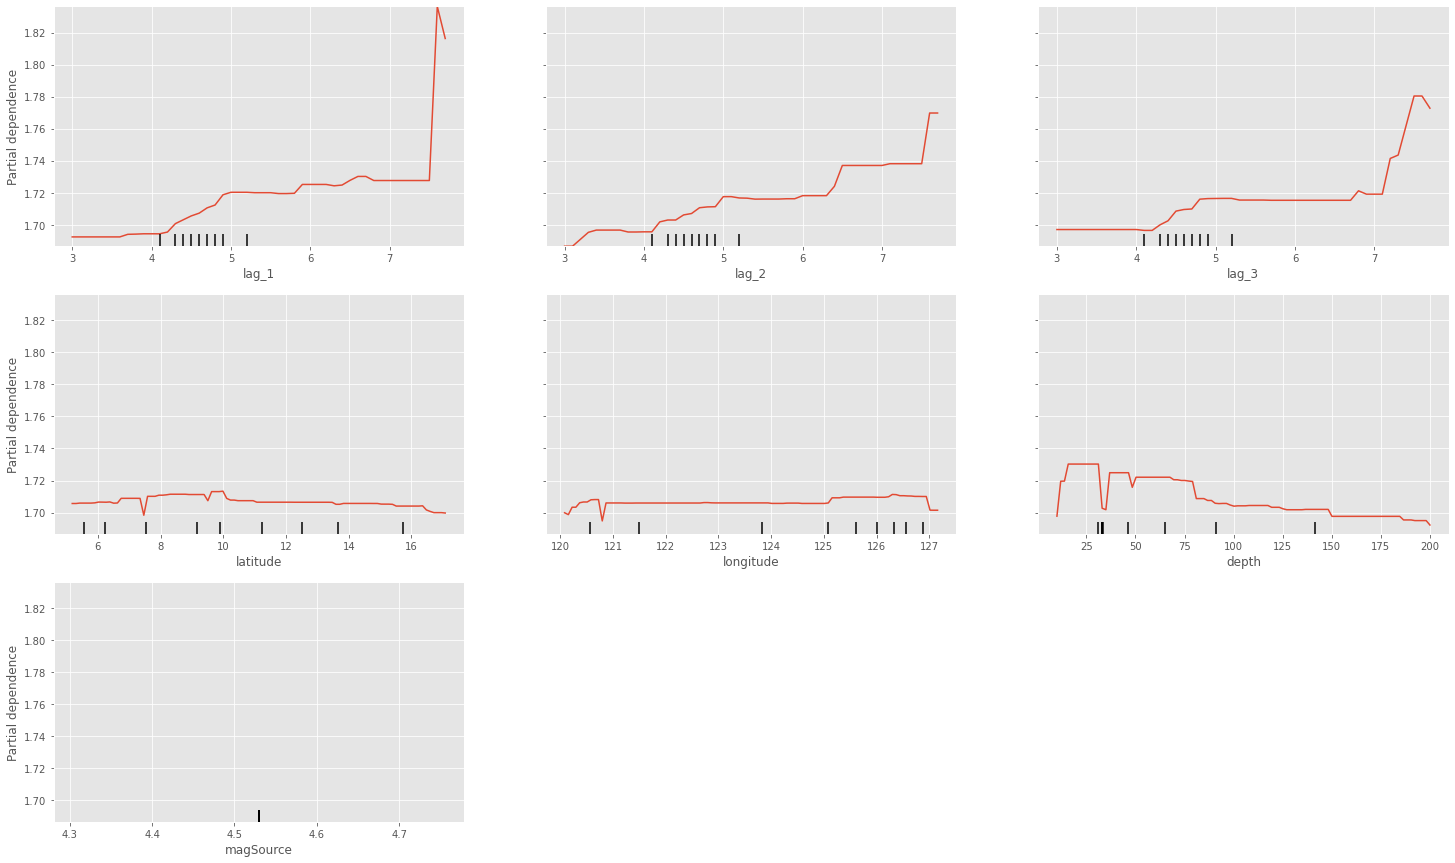

In [97]:
# Partial Dependence Plot
plt.rcParams['figure.figsize']=(25,15)
PartialDependenceDisplay.from_estimator(GBM_model,X_t,
['lag_1','lag_2','lag_3','latitude','longitude','depth','magSource'], 
                                        kind='average', random_state=0)
print("Partial dependence of Earthquake Magnitude on features with HGBM model")
plt.show()

### Neural Networks

In [98]:
# Evaluation following quantile approach
NN = MLPRegressor(hidden_layer_sizes=(15), activation='relu', solver='adam', 
                  max_iter=100,random_state=0)
param_grid = {}
NN_model = GridSearchCV(NN,param_grid,cv=ts_cv)
NN_model.fit(X_train_sc, np.log1p(y_train_sc))
nn_mean = NN_model.predict(X_test_sc)


In [99]:
def quantile_loss(q, y, y_p):
        e = y-y_p
        return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

In [100]:
qNN_model = tf.keras.models.Sequential()
qNN_model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=7))
qNN_model.add(tf.keras.layers.Dense(1, activation='linear'))
quantile = 0.05
qNN_model.compile(optimizer='adam', loss=lambda y, y_p: quantile_loss(quantile, y, y_p))
qNN_model.fit(X_train_sc, y_train_sc, epochs=100)
qNN_lower = qNN_model.predict(X_test_sc)

Epoch 1/100
278/278 [==============================] - 2s 2ms/step - loss: 0.0142
Epoch 2/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 3/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 4/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 5/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 6/100
278/278 [==============================] - 1s 3ms/step - loss: 0.0119
Epoch 7/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 10/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 11/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 12/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 13/100


In [101]:
qNN_model = tf.keras.models.Sequential()
qNN_model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=7))
qNN_model.add(tf.keras.layers.Dense(1, activation='linear'))
quantile = 0.5
qNN_model.compile(optimizer='adam', loss=lambda y, y_p: quantile_loss(quantile, y, y_p))
qNN_model.fit(X_train_sc, y_train_sc, epochs=100)
qNN_median = qNN_model.predict(X_test_sc)

Epoch 1/100
278/278 [==============================] - 1s 2ms/step - loss: 0.1002
Epoch 2/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0446
Epoch 3/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 4/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 5/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 6/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 7/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 8/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 9/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 10/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 11/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 12/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0431
Epoch 13/100


In [102]:
qNN_model = tf.keras.models.Sequential()
qNN_model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=7))
qNN_model.add(tf.keras.layers.Dense(1, activation='linear'))
quantile = 0.95
qNN_model.compile(optimizer='adam', loss=lambda y, y_p: quantile_loss(quantile, y, y_p))
qNN_model.fit(X_train_sc, y_train_sc, epochs=100)
qNN_upper = qNN_model.predict(X_test_sc)

Epoch 1/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0904
Epoch 2/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 3/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 4/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 5/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 6/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 7/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 8/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 9/100
278/278 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 10/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 11/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 12/100
278/278 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 13/100


In [103]:
print('Test evaluation')
rmse_nn_mean = np.sqrt(mean_squared_error(np.log1p(y_test_sc), nn_mean))
print(f"root_mean_squared_error_nn_mean: {rmse_nn_mean:.3f}")
rmse_qnn_lower = np.sqrt(mean_squared_error(np.log1p(y_test_sc), qNN_lower))
print(f"root_mean_squared_error_qnn_lower: {rmse_qnn_lower:.3f}")
rmse_qnn_median = np.sqrt(mean_squared_error(np.log1p(y_test_sc), qNN_median))
print(f"root_mean_squared_error_qnn_median: {rmse_qnn_median:.3f}")
rmse_qnn_upper = np.sqrt(mean_squared_error(np.log1p(y_test_sc), qNN_upper))
print(f"root_mean_squared_error_qnn_upper: {rmse_qnn_upper:.3f}")


Test evaluation
root_mean_squared_error_nn_mean: 0.120
root_mean_squared_error_qnn_lower: 0.118
root_mean_squared_error_qnn_median: 0.168
root_mean_squared_error_qnn_upper: 0.342


In [104]:
# Transformations
qNN_lower_ = scaling.inverse_transform(np.expm1(qNN_lower).reshape(-1,1))
qNN_median_ = scaling.inverse_transform(np.expm1(qNN_median).reshape(-1,1))
qNN_upper_ = scaling.inverse_transform(np.expm1(qNN_upper).reshape(-1,1))

In [105]:
# 5 Percentile
(qNN_lower_ > y_test.values).mean()

0.35168613887268996

In [106]:
# Median Percentile
(qNN_median_ > y_test.values).mean()

0.8869070361358563

In [107]:
# 95 Percentile
(qNN_upper_ > y_test.values).mean()

0.9949928613082909

In [108]:
# Coverage
np.logical_and(
    qNN_lower_ < y_test.values,
    qNN_upper_ > y_test.values,
).mean()

0.6433067224356009

In [109]:
# Features Importance
print('NN Features Permutation Importance')
NN_perm = PermutationImportance(NN_model, random_state=0).fit(X_test_sc, np.log1p(y_test_sc))
eli5.show_weights(NN_perm, feature_names = X_test.columns.tolist())

NN Features Permutation Importance


Weight,Feature
0.0811 ± 0.0688,longitude
0.0716 ± 0.0788,lag_1
0.0080 ± 0.0480,lag_3
0.0061 ± 0.0127,depth
0 ± 0.0000,magSource
-0.0162 ± 0.0350,latitude
-0.0462 ± 0.0838,lag_2


Partial dependence of Earthquake Magnitude on features with NN model


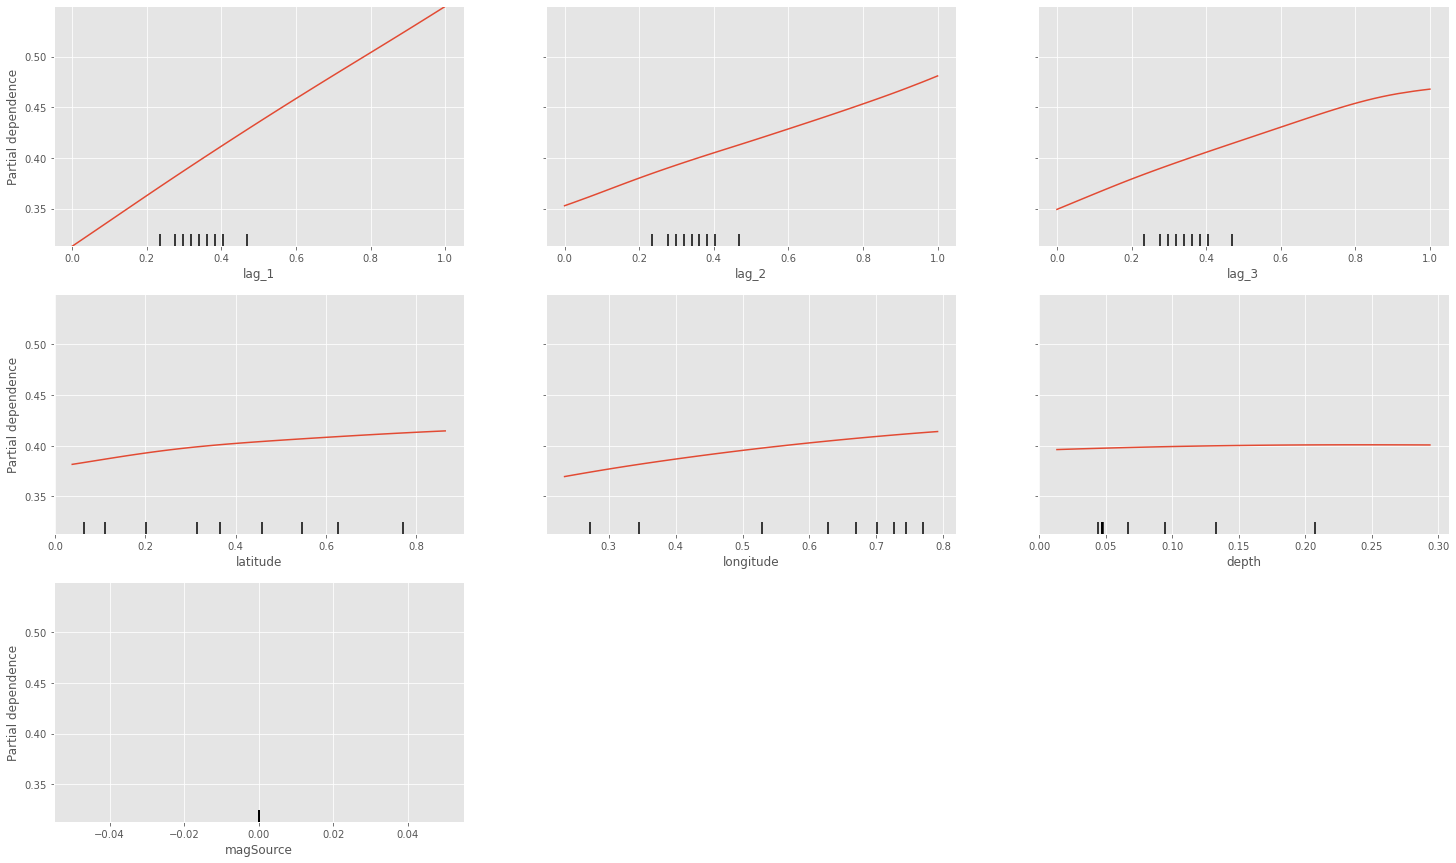

In [110]:
# Partial Dependence Plot
plt.rcParams['figure.figsize']=(25,15)
PartialDependenceDisplay.from_estimator(NN_model,X_sc,
['lag_1','lag_2','lag_3','latitude','longitude','depth','magSource'], 
                                        kind='average', random_state=0)
print("Partial dependence of Earthquake Magnitude on features with NN model")
plt.show()